# import funcs and load hydrographics profiles ds

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 40
mpl.rcParams["axes.titlesize"] = 40
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["font.size"] = 20
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

### load stuff

In [2]:
# QC'ed data with mixed layer
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/qc_profile_ds_2dbar.nc')

In [3]:
# take only profiles south of SAF, which is max at -40.5°S
idx = np.where(ds.lat < -40)[0]

ds = ds.sel(pres=slice(10,400)).isel(n_prof=idx)
ds['n_prof'] = np.arange(ds.n_prof.size)

# calculate n2 and add to ds
g = 9.8
rho0 = 1025
ds['n2'] = -g/rho0 * ds.rho.diff(dim='pres') / -ds.pres.diff('pres')

ds['sig'] = gsw.sigma0(ds.asal, ds.ctemp)

KeyboardInterrupt: 

In [ ]:
idx.size

In [ ]:
ds

# smoothing inspection

## inspect first on 50 random profiles

In [21]:
from scipy.ndimage import gaussian_filter1d as gf
from scipy.signal  import savgol_filter as sgf

In [18]:
# inspect 50 random profiles that are ~south of PF (so likely contain WW)
# note pf min position -72.5° and mean is -54°

from random import randint

idx = np.where(ds.lat < -54)[0]
tmp = ds.sel(pres=slice(10,400)).isel(n_prof=idx) 

idx = []
for i in range(100):
    idx += randint(0,tmp.n_prof.size-1),

chk = tmp.isel(n_prof=idx)

Text(0.5, 0.98, 'savitzky golay filter')

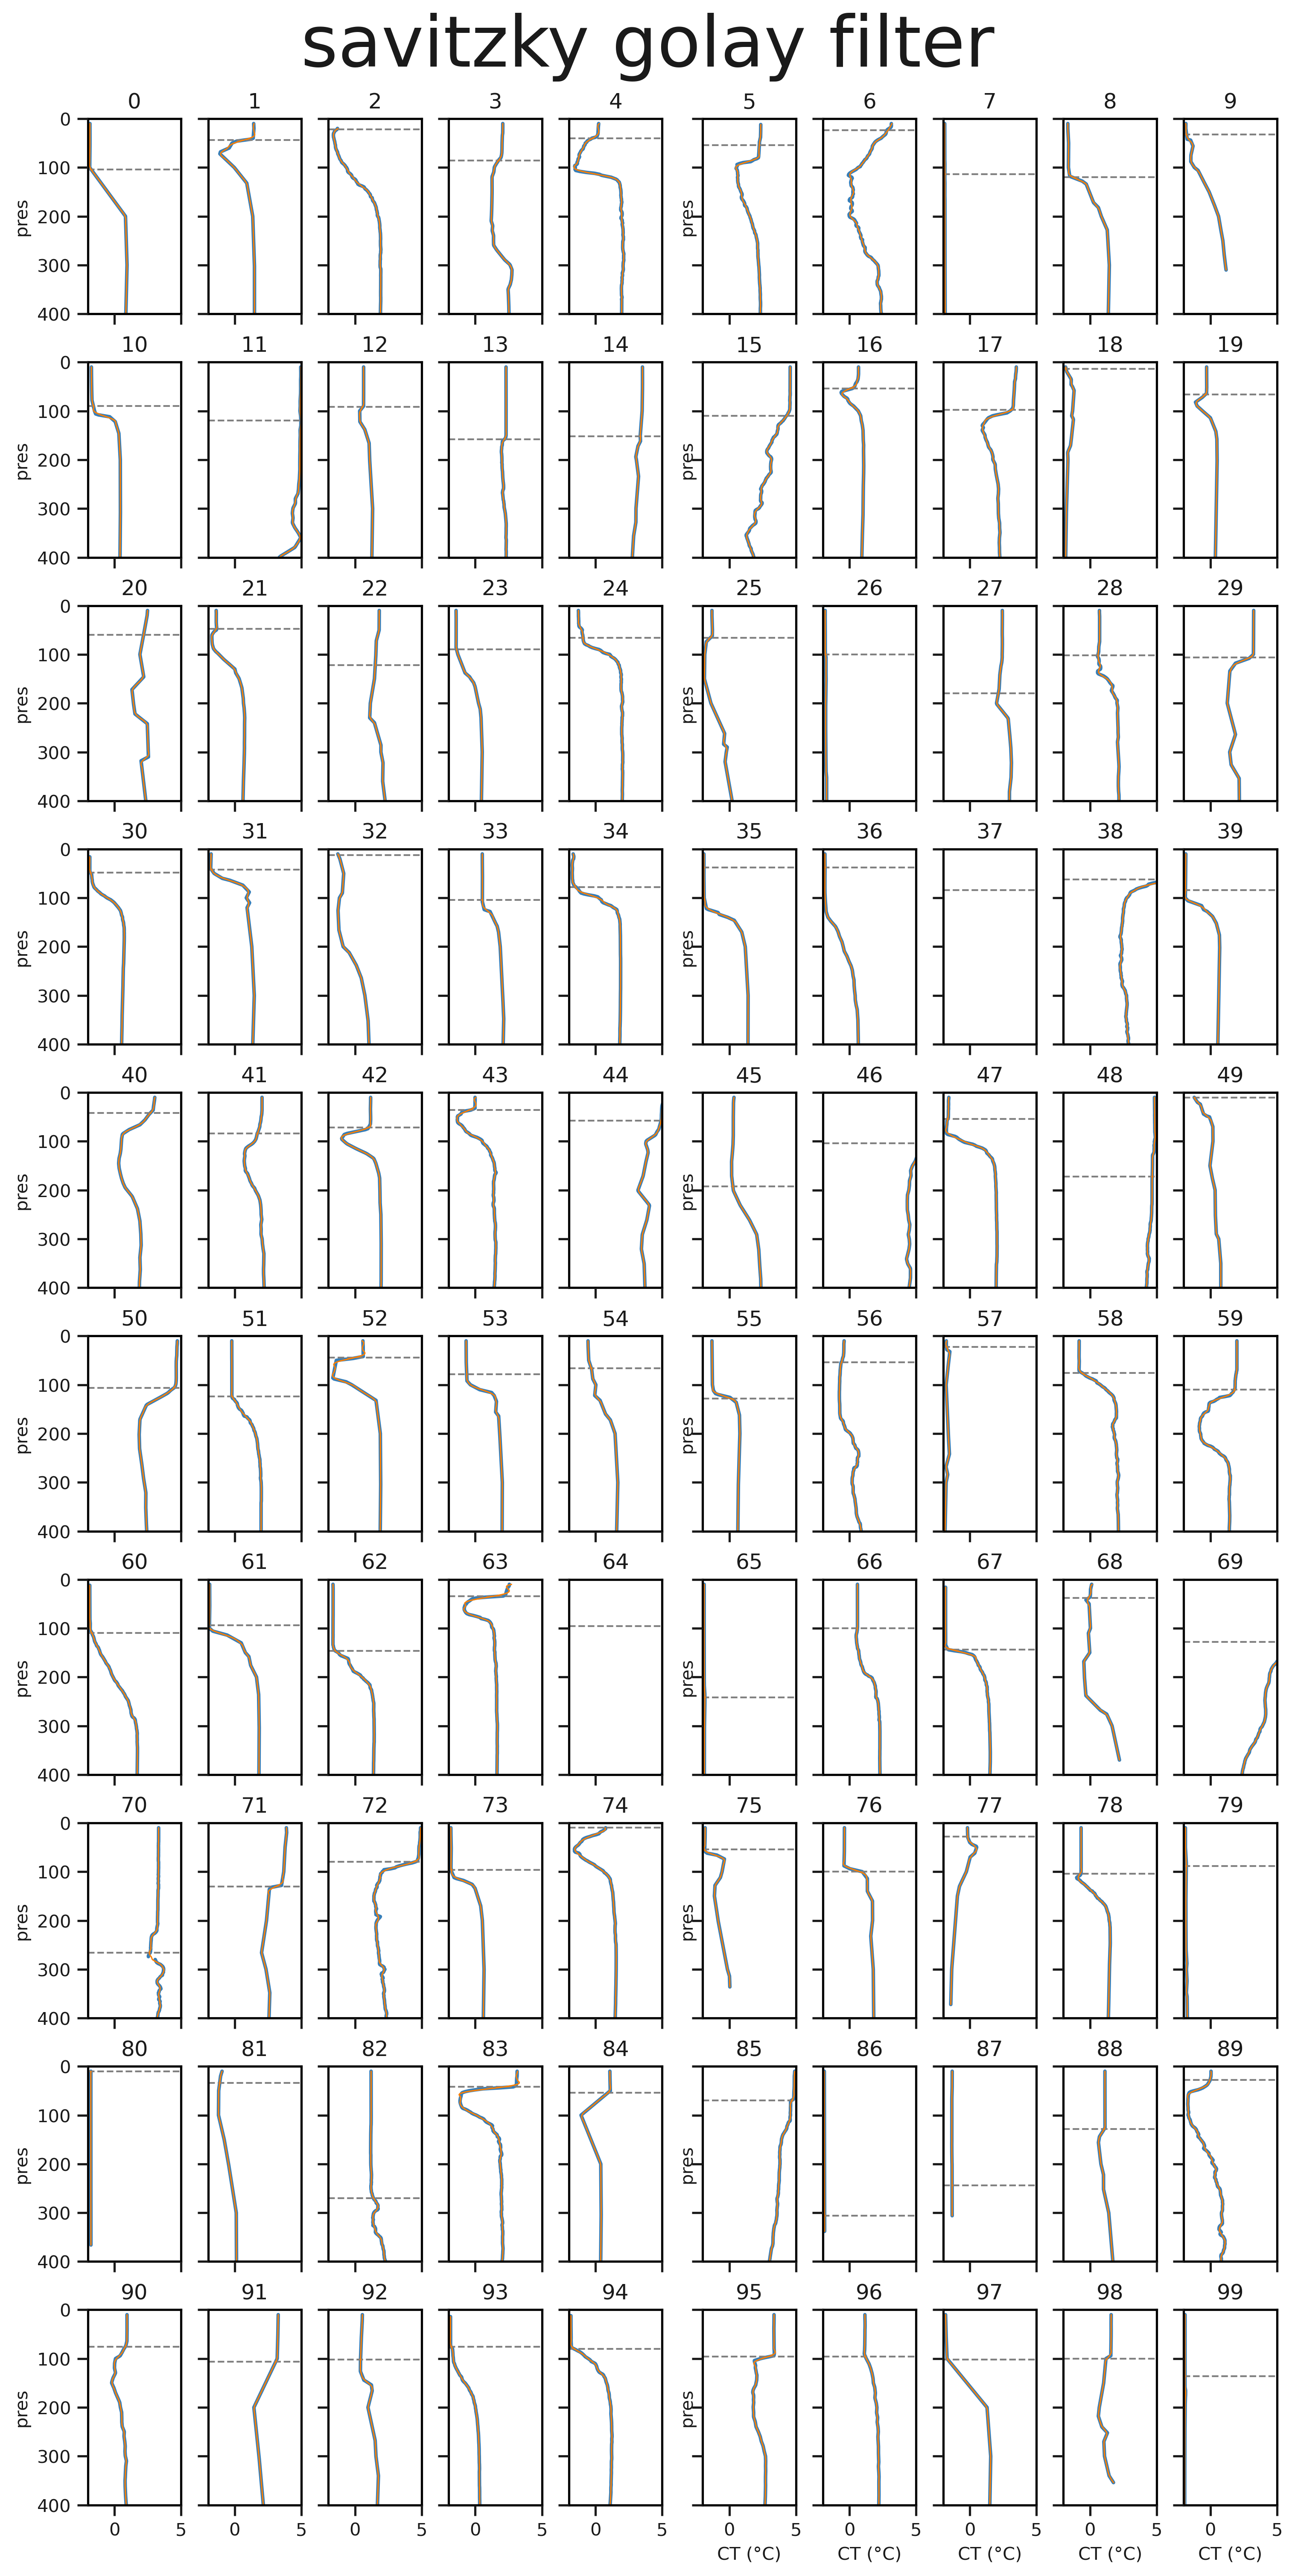

In [23]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

m = 21
n = 4

fig,ax = plt.subplots(10,10,figsize=[10,20],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.isel(n_prof=i).ctemp
    
    tmp2.plot(y='pres',ax=a,c='#377eb8',lw=2)
    a.axes.axhline(chk.isel(n_prof=i).mlp,ls='--',c='grey',lw=1)
    a.plot(sgf(tmp2[np.isfinite(tmp2)],m,n),
           tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=0.75)
   # a.plot(gf(tmp2[np.isfinite(tmp2)],2),
    #       tmp.pres[np.isfinite(tmp2.data)],c='#4daf4a',lw=.75)
    
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)
    a.axes.invert_yaxis()
    a.set_ylim(400,0)
    
for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.suptitle('savitzky golay filter')

Text(0.5, 0.98, 'gauss filter')

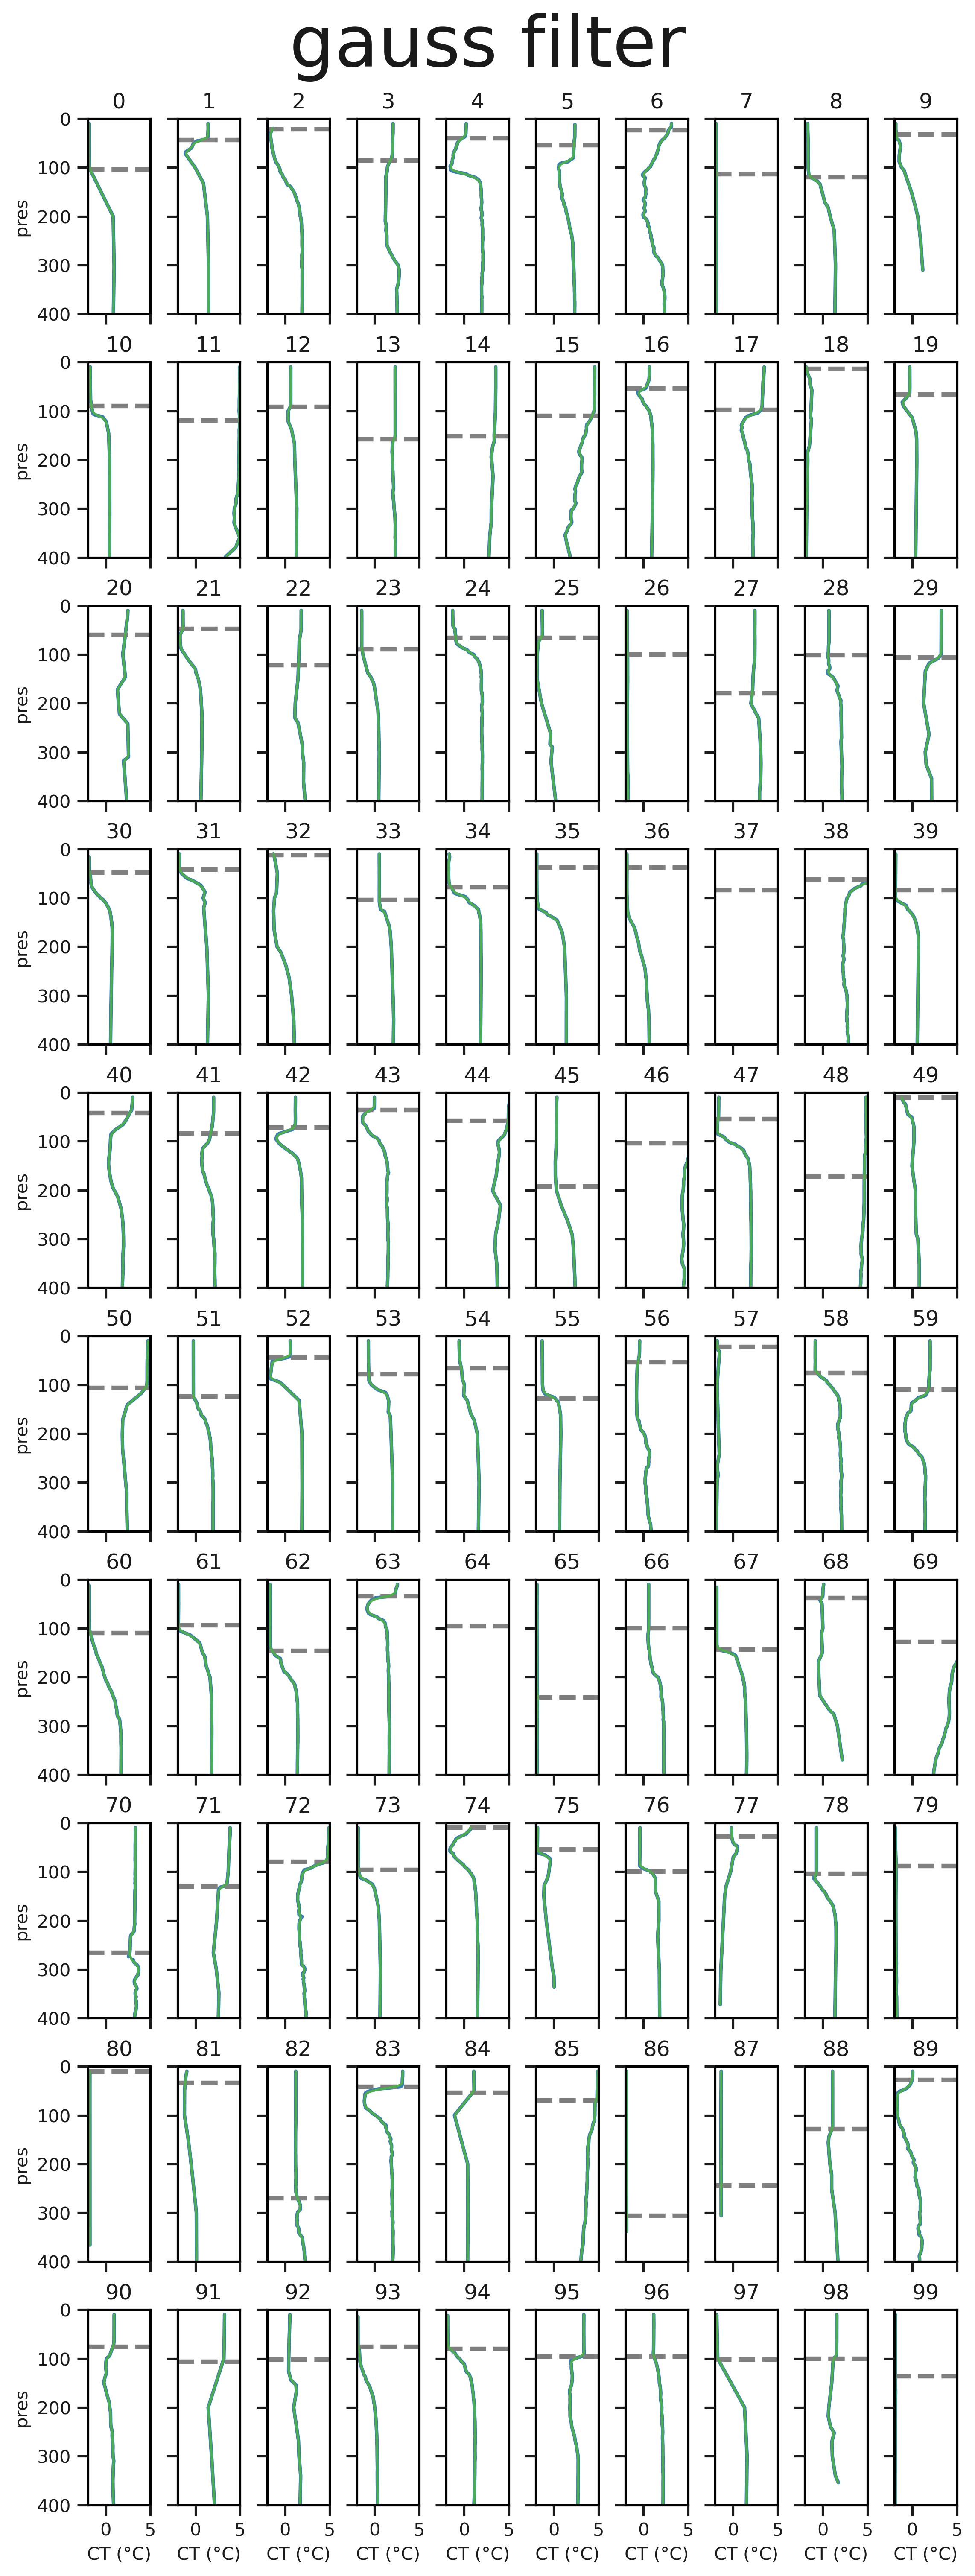

In [24]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

x=10
fig,ax = plt.subplots(x,10,figsize=[7.5,20],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.isel(n_prof=i).ctemp
    
    tmp2.plot(y='pres',ax=a,c='#377eb8',lw=2)
    a.axes.axhline(chk.isel(n_prof=i).mlp,ls='--',c='grey',lw=2.5)
 #   a.plot(sgf(tmp2[np.isfinite(tmp2)],m,n),
  #         tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=0.75)
    a.plot(gf(tmp2[np.isfinite(tmp2)],2),
           tmp.pres[np.isfinite(tmp2.data)],c='#4daf4a',lw=1.25)
    
    
    
    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)
    a.set_ylim(400,0)

for i,a in enumerate(ax[::x]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-x:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.suptitle('gauss filter')

In [34]:
tmp2

<xarray.Dataset>
Dimensions:  (pres: 196)
Coordinates:
    lon      float64 ...
    lat      float64 -71.04
    time     datetime64[ns] ...
    n_prof   int64 643059
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
Data variables:
    ctemp    (pres) float32 ...
    mlp      int64 ...
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

Text(0.5, 0.98, 'difference with mixed layer temperature')

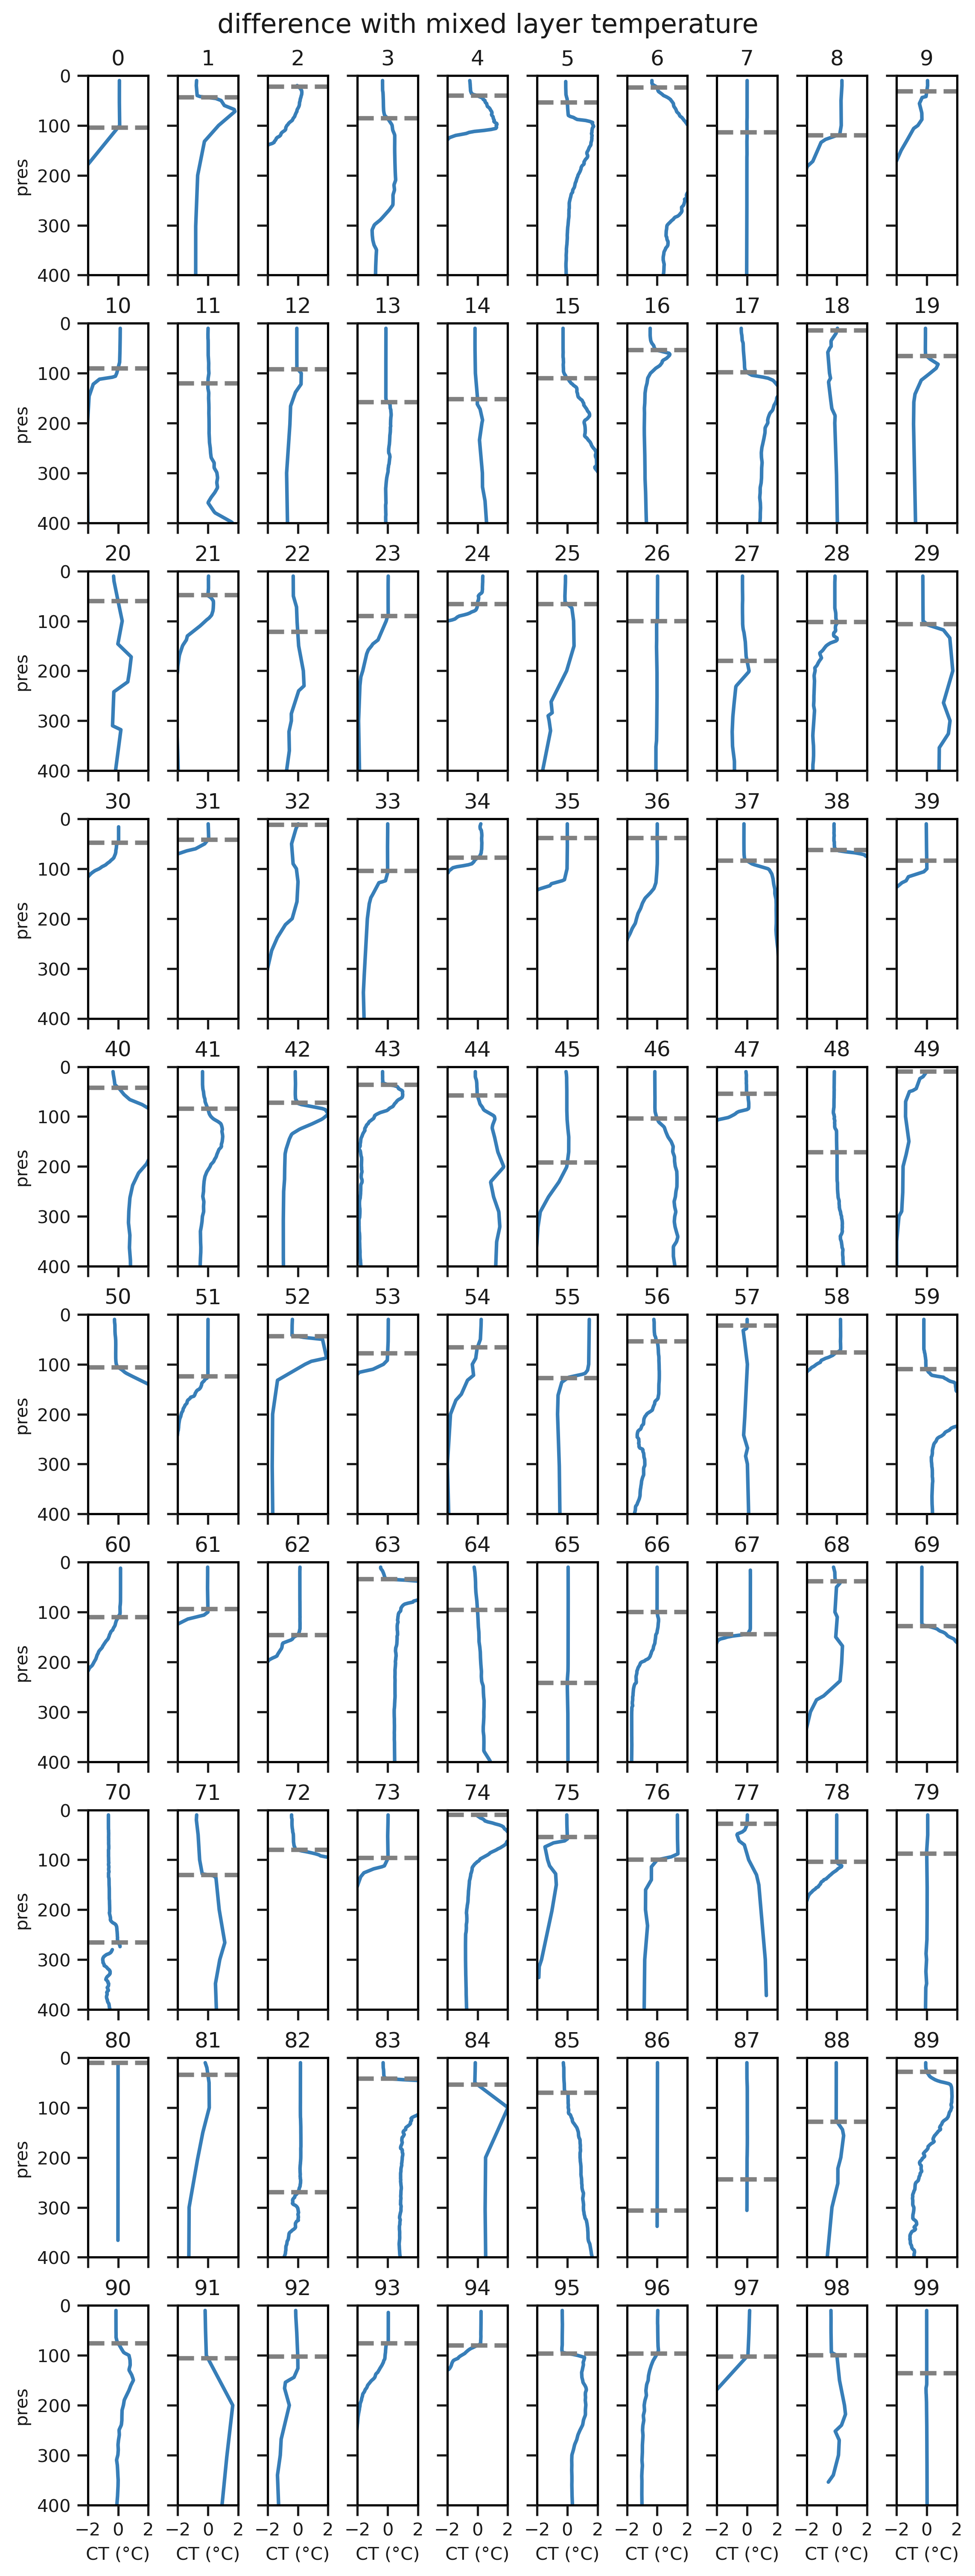

In [40]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

x=10
fig,ax = plt.subplots(x,10,figsize=[7.5,20],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.isel(n_prof=i)[['ctemp','mlp']]
    
    (tmp2.sel(pres=tmp2.mlp.data).ctemp - tmp2.ctemp).plot(y='pres',ax=a,c='#377eb8',lw=2)
    a.axes.axhline(chk.isel(n_prof=i).mlp,ls='--',c='grey',lw=2.5)
 #   a.plot(sgf(tmp2[np.isfinite(tmp2)],m,n),
  #         tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=0.75)
#    a.plot(gf(tmp2[np.isfinite(tmp2)],2),
 #          tmp.pres[np.isfinite(tmp2.data)],c='#4daf4a',lw=1.25)
    
    
    
    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,2)
    
    a.set_title(i,fontsize=12)
    a.set_ylim(400,0)

for i,a in enumerate(ax[::x]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-x:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.suptitle('difference with ML temperature',fontsize=15)

Text(0.5, 0.98, 'Gaussian filter (1d, sd=2)')

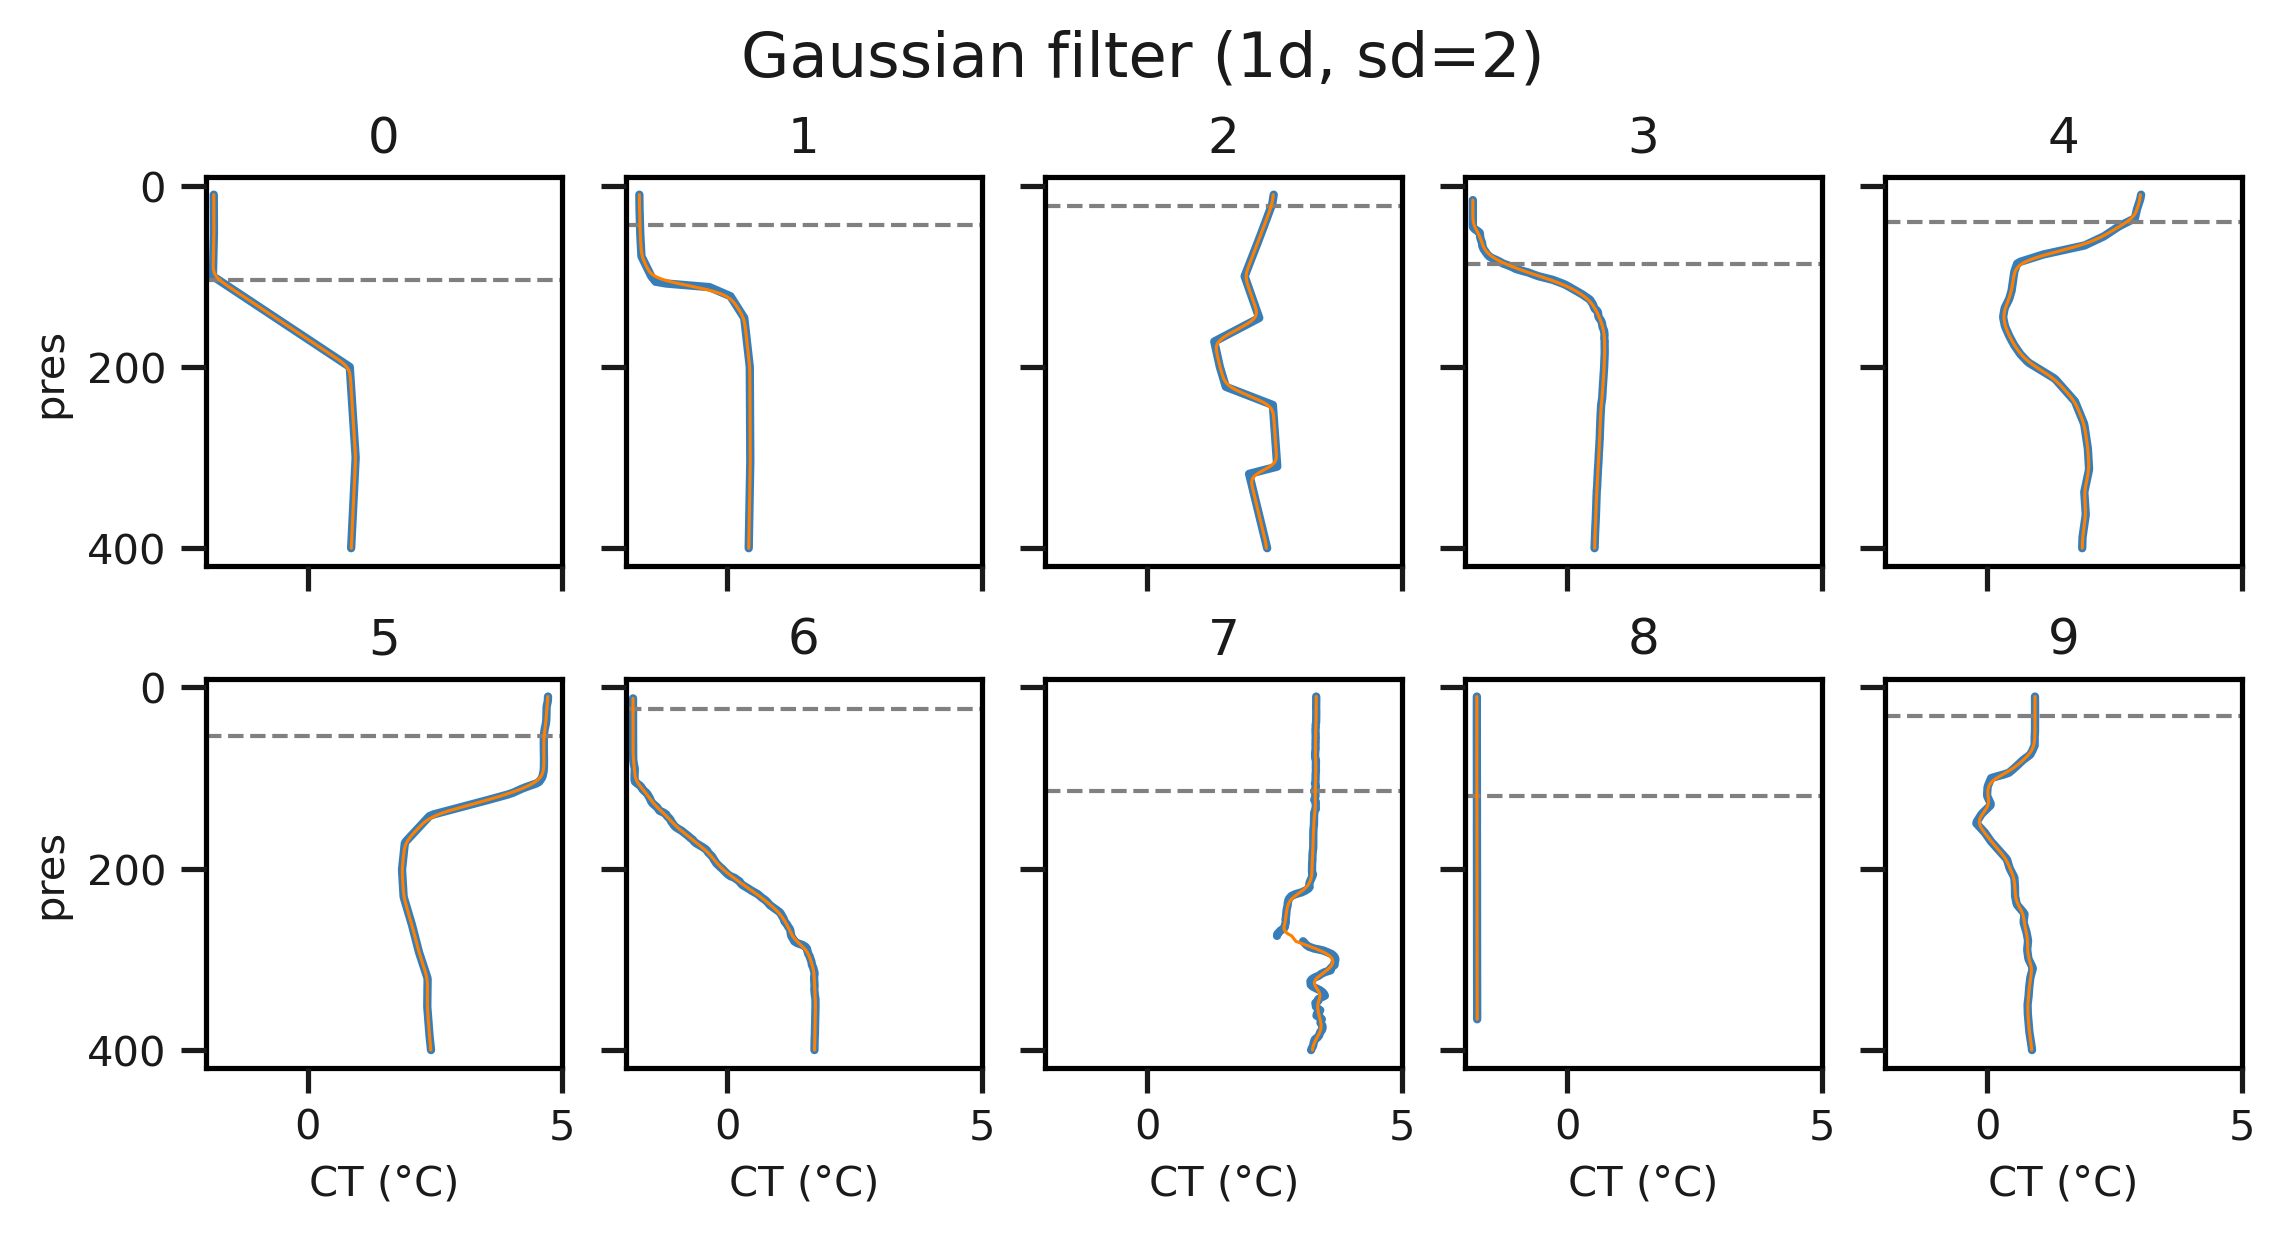

In [25]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

m = 21
n = 4

fig,ax = plt.subplots(2,5,figsize=[7.5,4],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.ctemp[::10].isel(n_prof=i)
    
    tmp2.plot(y='pres',ax=a,c='#377eb8',lw=2)
    a.axes.axhline(chk.isel(n_prof=i).mlp,ls='--',c='grey',lw=1)
 #   a.plot(sgf(tmp2[np.isfinite(tmp2)],m,n),
  #         tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=0.75)
    a.plot(gf(tmp2[np.isfinite(tmp2)],3),
           tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=.75)
    
    
    
    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)

for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.suptitle('Gaussian filter (1d, sd=2)',fontsize=15)

Text(0.5, 0.98, 'Savitsky Golay filter')

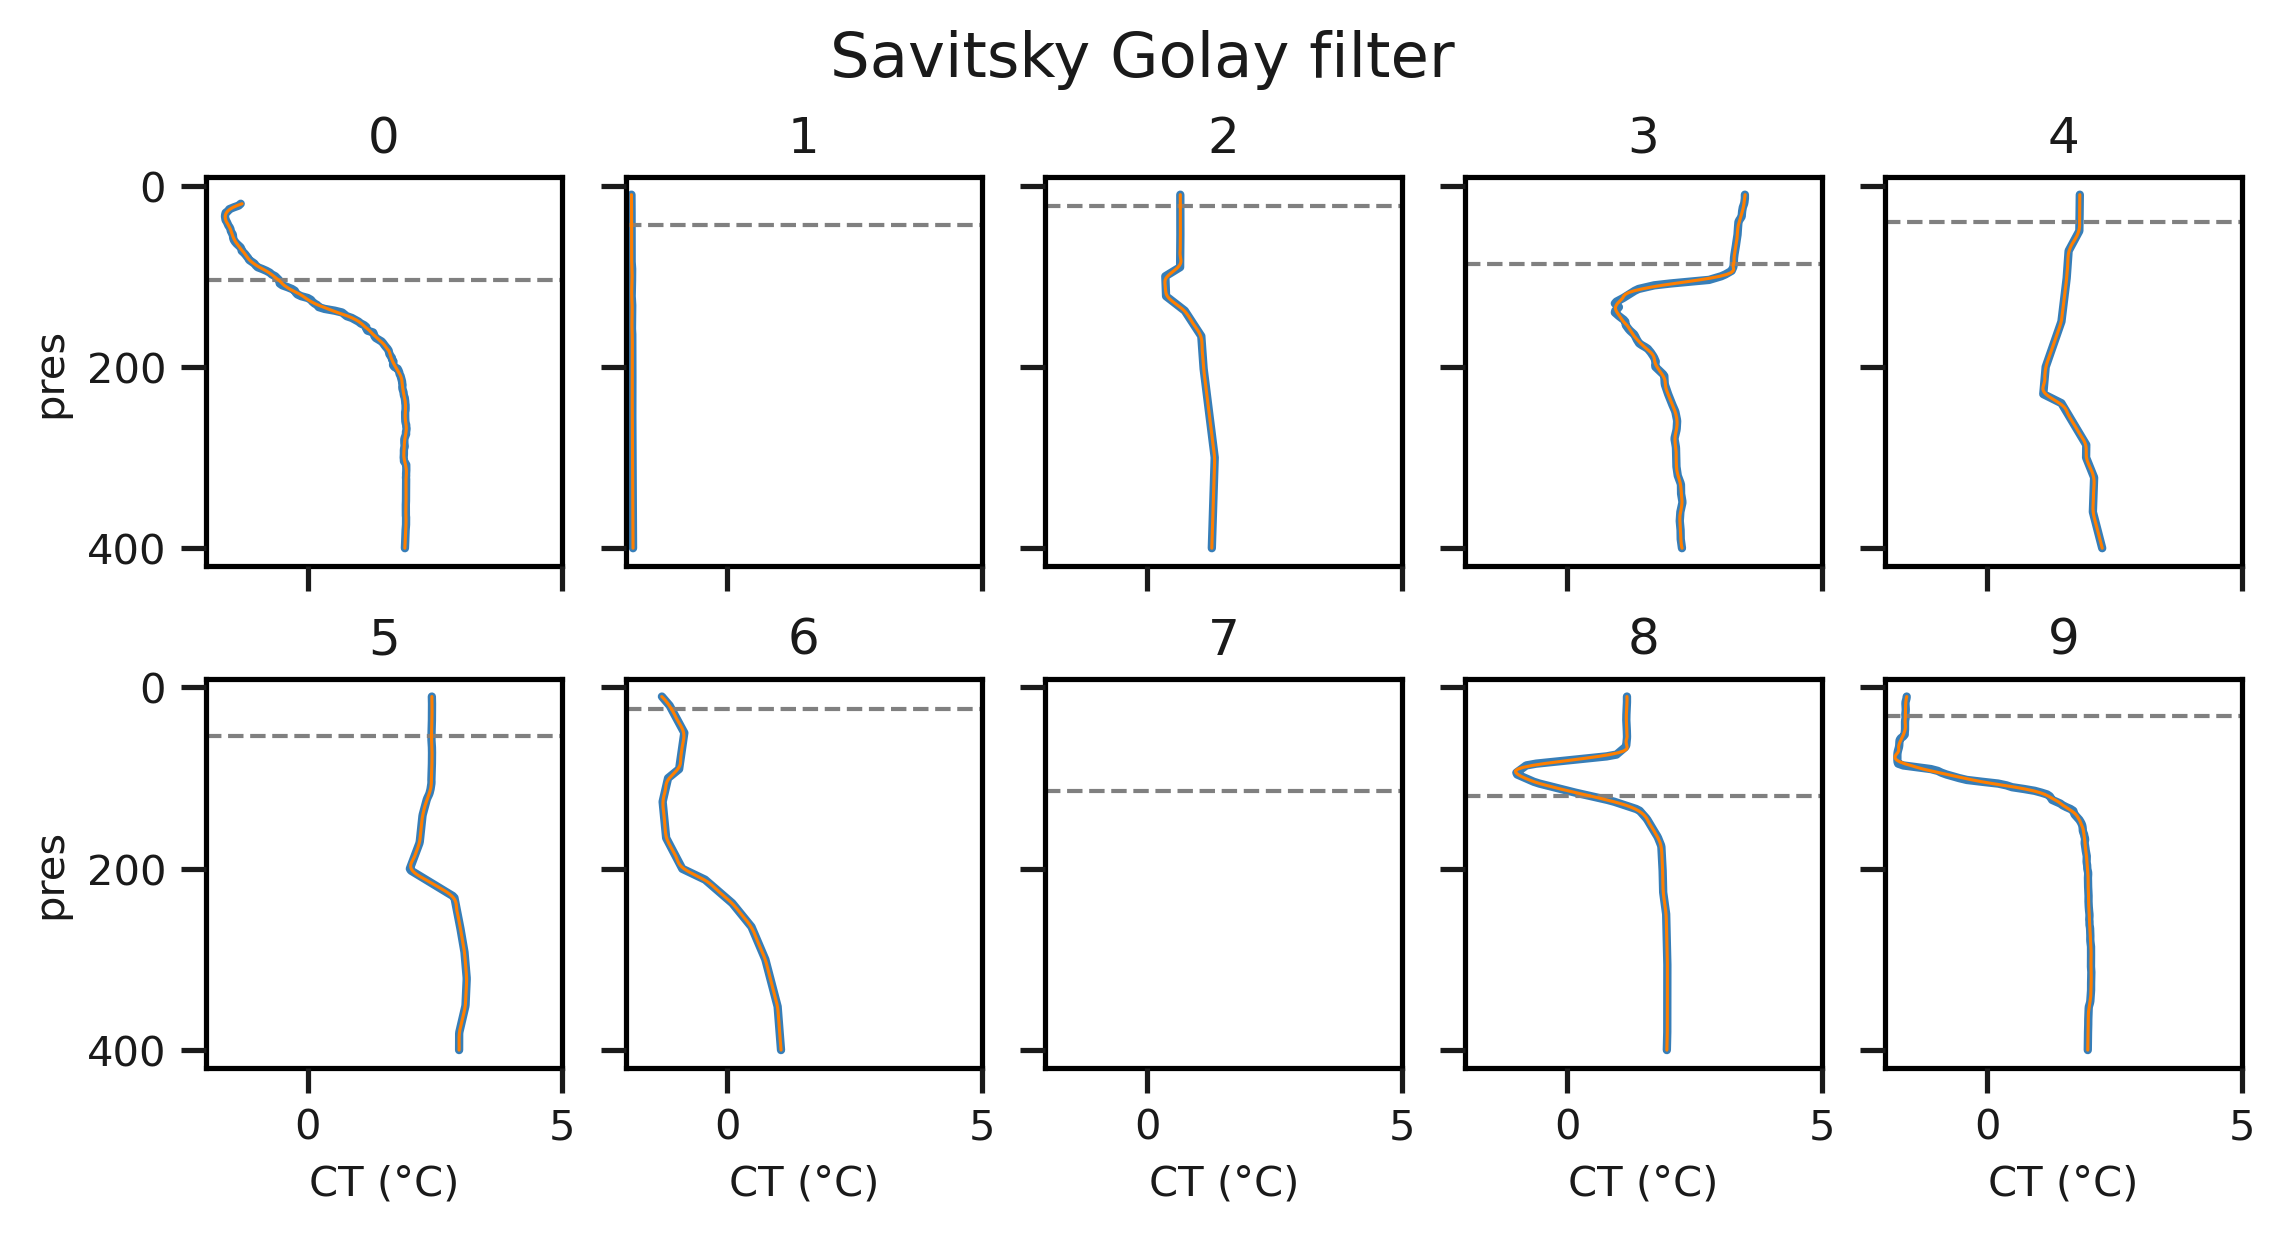

In [26]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

m = 21
n = 4

fig,ax = plt.subplots(2,5,figsize=[7.5,4],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.ctemp[2::5].isel(n_prof=i)
    
    tmp2.plot(y='pres',ax=a,c='#377eb8',lw=2)
    a.axes.axhline(chk.isel(n_prof=i).mlp,ls='--',c='grey',lw=1)
    a.plot(sgf(tmp2[np.isfinite(tmp2)],m,n),
           tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=0.75)
 #   a.plot(gf(tmp2[np.isfinite(tmp2)],3),
  #         tmp.pres[np.isfinite(tmp2.data)],c='#ff7f00',lw=.75)
    
    
    
    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)

for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.suptitle('Savitsky Golay filter',fontsize=15)

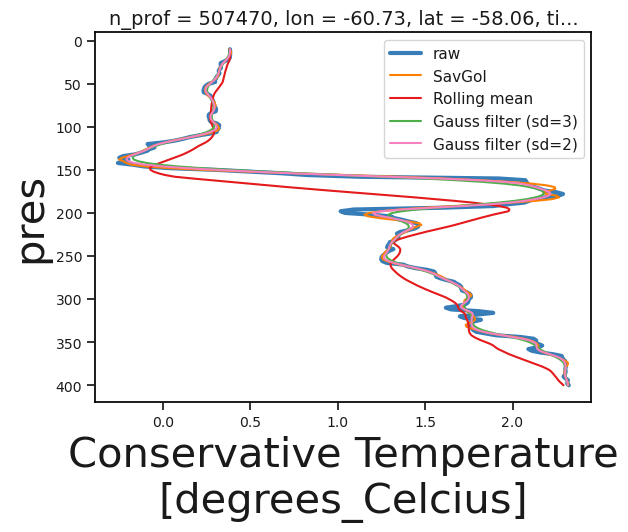

In [327]:
#m,n = 50,4

tmp = chk.isel(n_prof=45)

tmp.ctemp.plot(y='pres',lw=3,c='#377eb8')
plt.plot(sgf(tmp.ctemp[np.isfinite(tmp.ctemp)],m,n),
           tmp.pres[np.isfinite(tmp.ctemp.data)],c='#ff7f00',lw=1.5)

tmp.ctemp.rolling({'pres':20},min_periods=1).mean('pres').plot(y='pres',lw=1.5,c='#e41a1c')

plt.plot(gf(tmp.ctemp[np.isfinite(tmp.ctemp)],3),
           tmp.pres[np.isfinite(tmp.ctemp.data)],c='#4daf4a',lw=1.5)

plt.plot(gf(tmp.ctemp[np.isfinite(tmp.ctemp)],2),
           tmp.pres[np.isfinite(tmp.ctemp.data)],c='#f781bf',lw=1.5)

plt.gca().invert_yaxis()

plt.legend(['raw','SavGol','Rolling mean','Gauss filter (sd=3)','Gauss filter (sd=2)'])

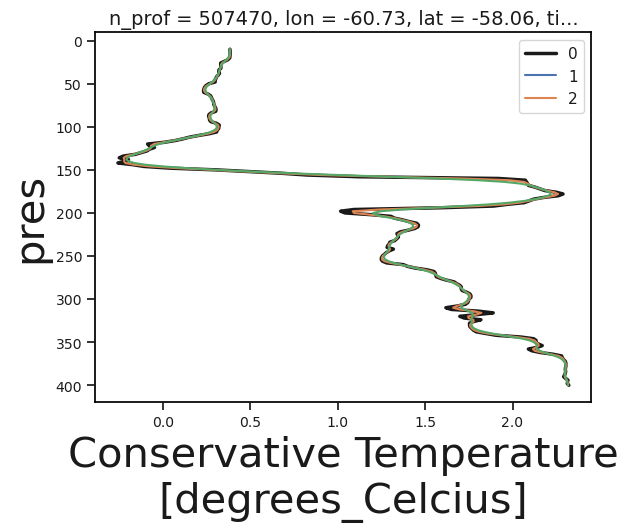

In [328]:
sig = np.arange(0,3,1)
tmp.ctemp.plot(y='pres',lw=2.5,c='k')
for i in sig:
    plt.plot(gf(tmp.ctemp[np.isfinite(tmp.ctemp)],i),
               tmp.pres[np.isfinite(tmp.ctemp.data)],lw=1.5)
plt.gca().invert_yaxis()

plt.legend(sig)

profile idx:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'gauss filtered profiles')

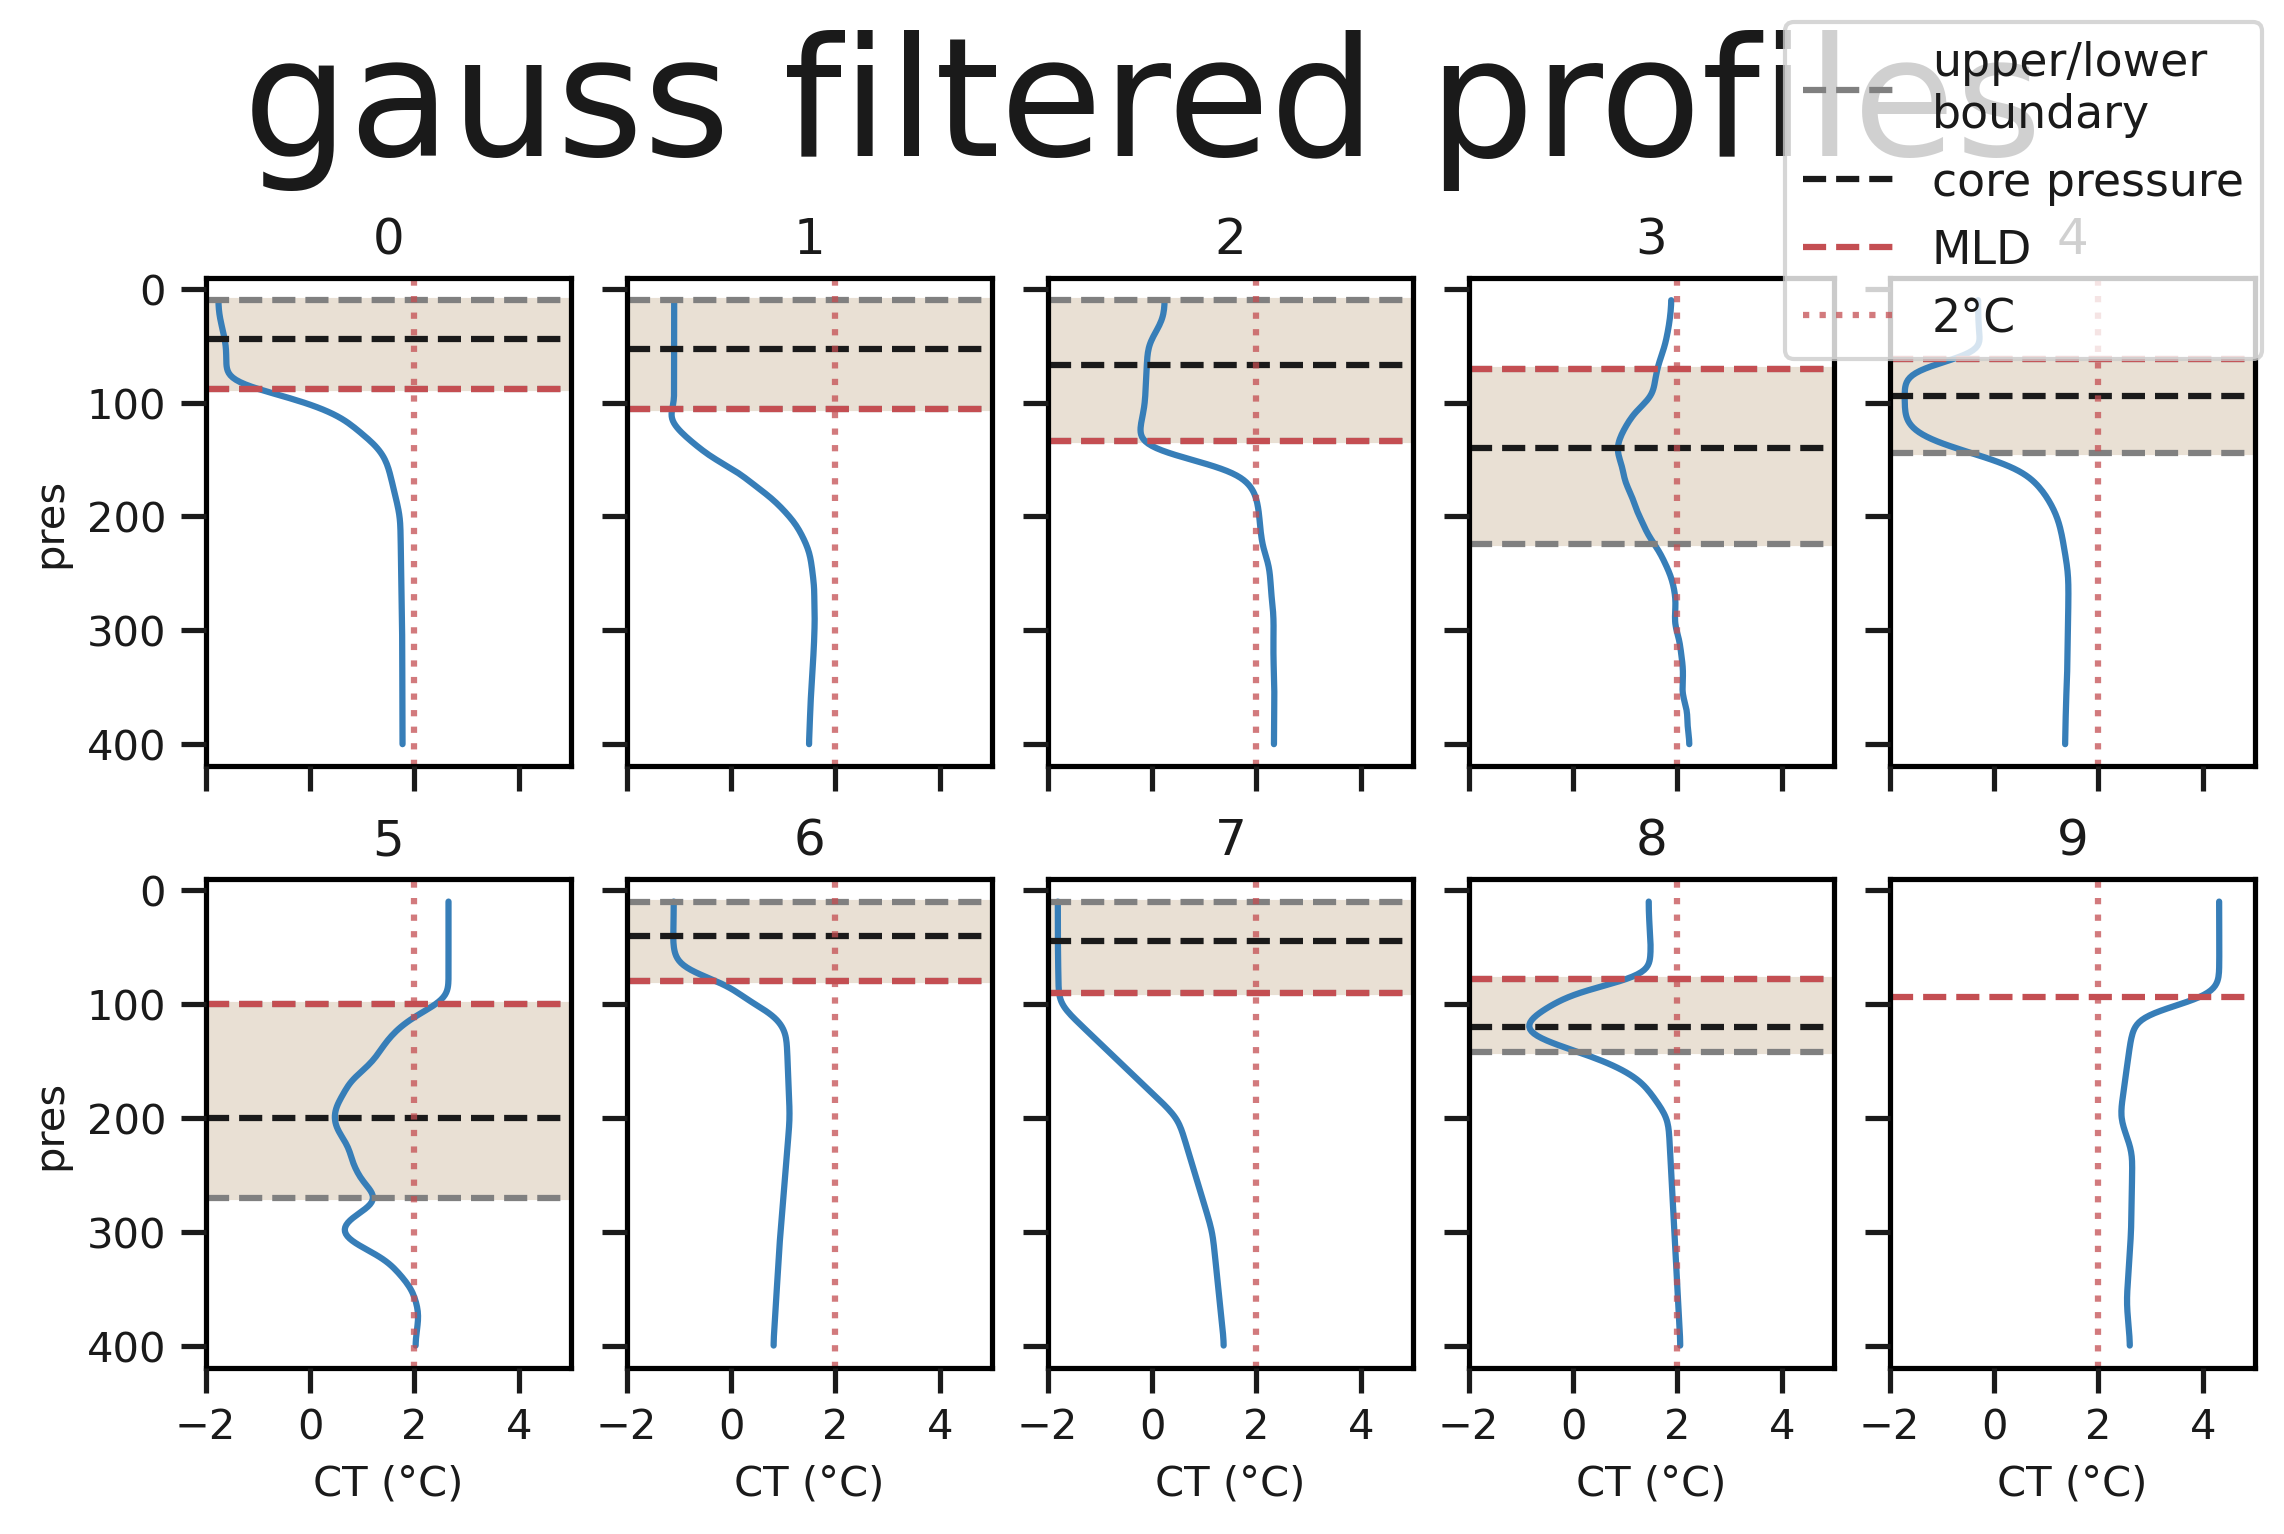

In [339]:
chk2 = chk.isel(n_prof=np.arange(0,100,11))

# gauss filtering of vars
dvars = ['ctemp','asal','rho','n2']
for d in dvars:
    chk2[d] = xr.DataArray(gf(chk2[d].data,4),dims={'n_prof':chk2.n_prof.data,'pres':chk2.pres.data},
                                        coords={'n_prof':chk2.n_prof.data,'pres':chk2.pres.data})
chk2 = calc_ww(chk2)

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig,ax = plt.subplots(2,5,figsize=[7.5,5],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk2.isel(n_prof=i)
    
    tmp2.ctemp.plot(y='pres',ax=a,c='#377eb8',lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(2,ls=':',c='r',alpha=0.75)

    
    a.axes.invert_yaxis()
#    a.set_title(int(tmp2.n_prof),fontsize=10)
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)
    a.set_xticks([-2,0,2,4])
    
    a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#e9e0d4')

for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('gauss filtered profiles')

profile idx:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'unfiltered profiles')

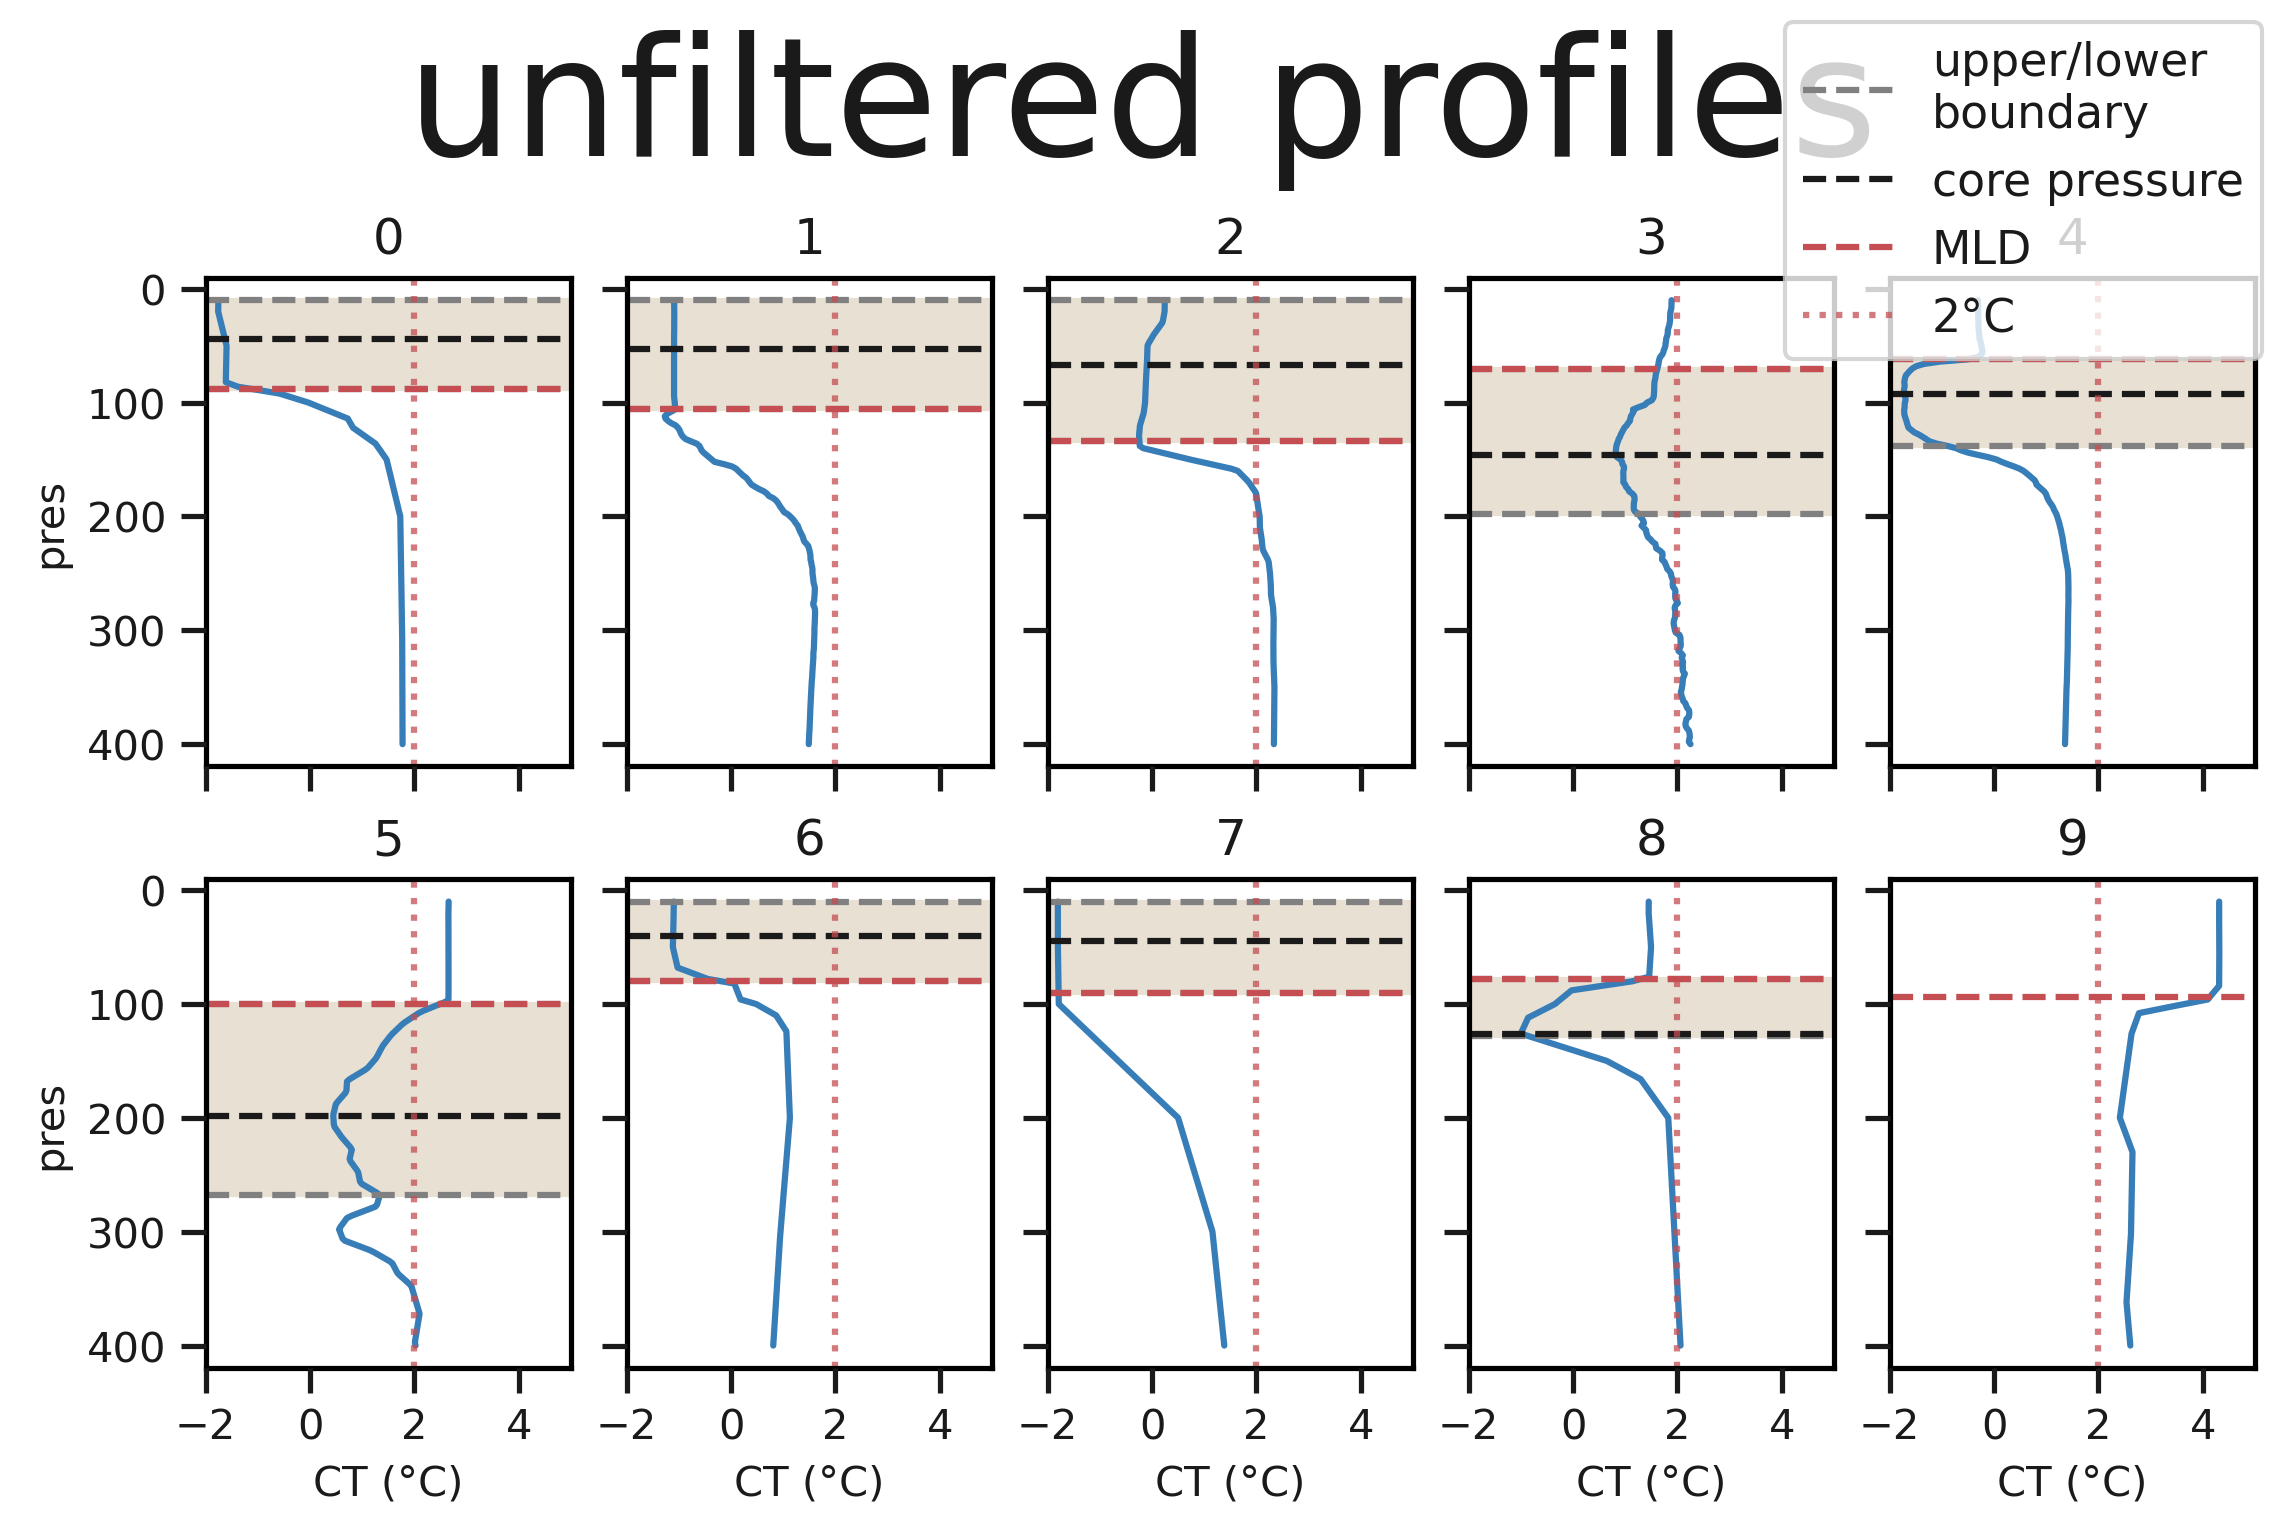

In [338]:
chk2 = chk.isel(n_prof=np.arange(0,100,11))
chk2 = calc_ww(chk2)

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig,ax = plt.subplots(2,5,figsize=[7.5,5],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk2.isel(n_prof=i)
    
    tmp2.ctemp.plot(y='pres',ax=a,c='#377eb8',lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(2,ls=':',c='r',alpha=0.75)

    
    a.axes.invert_yaxis()
    a.set_title(int(tmp2.n_prof),fontsize=10)
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)
    a.set_xticks([-2,0,2,4])
    
    a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#e9e0d4')

for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('unfiltered profiles')

## $T < T_{ML}$ for WW to exist below ML $\Rightarrow T - T_{ML} < 0 $

In [279]:
chk = calc_ww(chk)

profile idx:   0%|          | 0/50 [00:00<?, ?it/s]

In [280]:
chk

<xarray.Dataset>
Dimensions:  (n_prof: 50, pres: 196)
Coordinates:
  * n_prof   (n_prof) int64 461852 510722 164888 328297 ... 287599 208384 158210
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 -55.75 -70.31 -55.37 ... -60.14 -77.14 -63.62
    time     (n_prof) datetime64[ns] ...
Data variables: (12/17)
    temp     (n_prof, pres) float64 ...
    psal     (n_prof, pres) float64 ...
    dsource  (n_prof) object ...
    mld      (n_prof) float64 ...
    asal     (n_prof, pres) float32 ...
    ctemp    (n_prof, pres) float32 ...
    ...       ...
    ww_ct    (n_prof) float64 1.223 -1.785 0.1778 1.024 ... -0.6837 -1.92 -1.481
    ww_sa    (n_prof) float64 34.22 34.53 34.1 34.07 ... 34.6 34.2 34.77 34.33
    lw_bd    (n_prof) float64 240.0 68.0 134.0 110.0 ... 70.0 164.0 310.0 102.0
    ww_type  (n_prof) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    thcc     (n_prof) float64 230.0 58.0 76.0 18.0 92.0 ... 60.0 92.0 300.0 50.0
    ww_n2    (n_prof) float64 0.0001395 0.0001471 ... 5.602e-05 0.003564
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

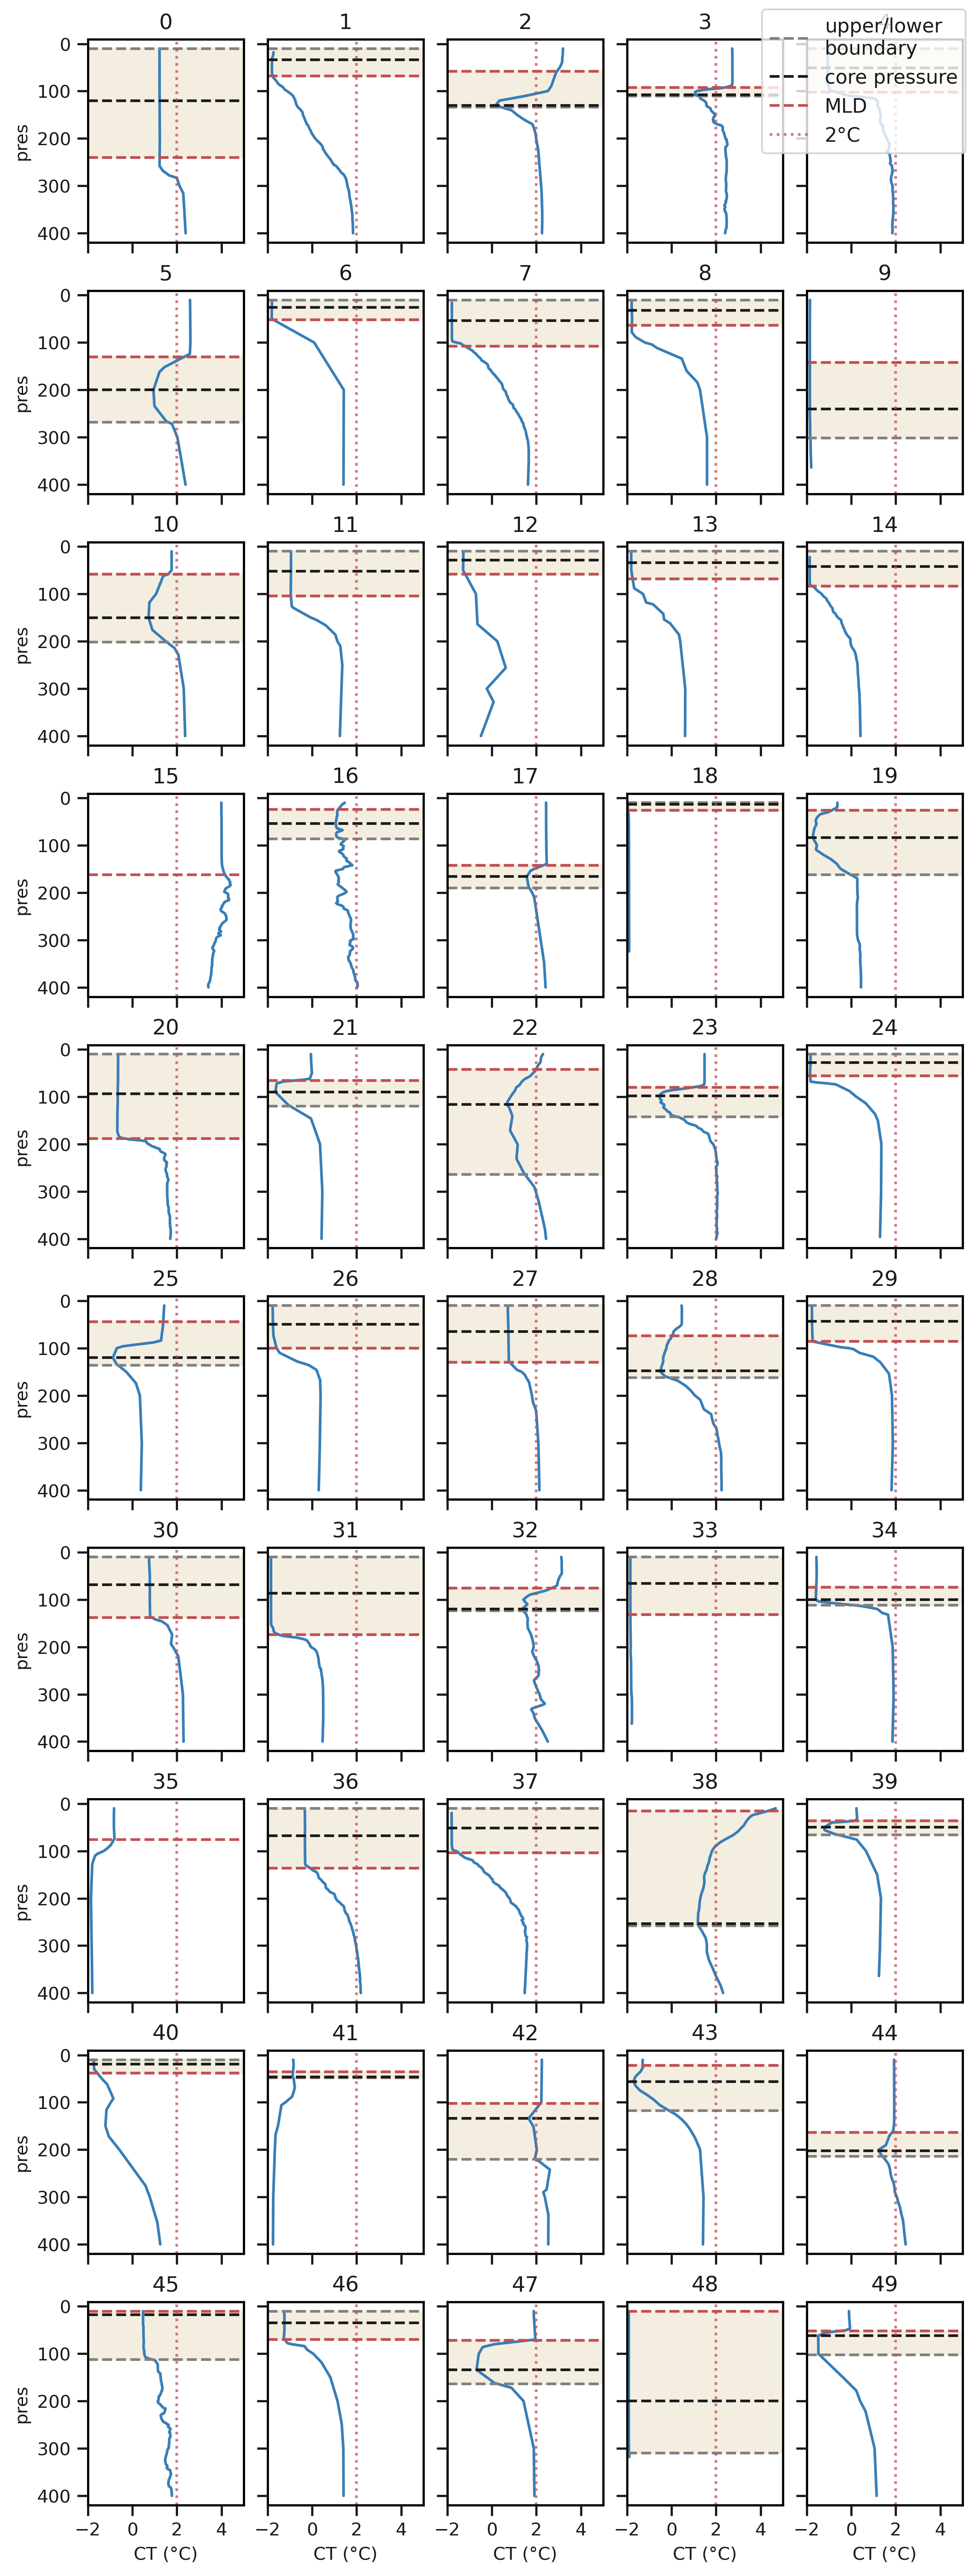

In [283]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

m = 21
n = 10

fig,ax = plt.subplots(10,5,figsize=[7.5,20],constrained_layout=True,dpi=300,sharex='col',sharey='row',
                     )
ax=ax.flatten()

for i,a in enumerate(ax):
    tmp2 = chk.isel(n_prof=i)
    
    tmp2.ctemp.plot(y='pres',ax=a,c='#377eb8',lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(2,ls=':',c='r',alpha=0.75)

    
    a.axes.invert_yaxis()
#    a.set_title(int(tmp2.n_prof),fontsize=10)
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2,5)
    
    a.set_title(i,fontsize=12)
    a.set_xticks([-2,0,2,4])
    a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

for i,a in enumerate(ax[::5]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-5:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

# run smoothing on temp and psal then calc asal, ct, mlp and n2

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

In [3]:
# QC'ed data with mixed layer
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/qc_profile_ds_2dbar.nc')

# take only profiles south of SAF, which is max at -40.5°S
idx = np.where(ds.lat < -40)[0]

ds = ds.sel(pres=slice(10,400)).isel(n_prof=idx)
ds['n_prof'] = np.arange(ds.n_prof.size)

In [3]:
idx.size

620293

In [4]:
# Import necessary libraries and modules
from scipy.ndimage import gaussian_filter1d as gf  # Import the Gaussian filter function from SciPy
import xarray as xr  # Import xarray for working with labeled multi-dimensional arrays

# Define a function for Gaussian filtering of vertical profiles in a dataset
def gauss_filter_z(ds, dvars=['temp', 'psal'], std=4):
    """
    Apply Gaussian filtering to vertical profiles of selected variables in a dataset.

    Parameters:
    -----------
    ds : xarray.Dataset
        The input dataset containing vertical profiles of oceanographic variables.

    dvars : list of str, optional
        A list of variable names to which Gaussian filtering will be applied.
        Default is ['temp', 'psal'].

    std : int or float, optional
        The standard deviation of the Gaussian filter. Default is 4.

    Returns:
    --------
    ds : xarray.Dataset
        The modified dataset with Gaussian-filtered variables.
    """
    # Iterate through the specified variables for Gaussian filtering
    for d in dvars:
        # Apply Gaussian filtering with the specified standard deviation
        ds[d] = xr.DataArray(
            gf(ds[d].data, std),  # Gaussian filter with the specified standard deviation
            dims={'n_prof': ds.n_prof.data, 'pres': ds.pres.data},  # Preserve dimensions
            coords={'n_prof': ds.n_prof.data, 'pres': ds.pres.data}  # Preserve coordinates
        )
        
    return ds  # Return the modified dataset with Gaussian-filtered variables

In [5]:
ds = gauss_filter_z(ds)

In [6]:
ds

<xarray.Dataset>
Dimensions:  (n_prof: 620293, pres: 196)
Coordinates:
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 -57.46 -69.32 -58.43 ... -41.05 -42.42 -65.83
    time     (n_prof) datetime64[ns] ...
  * n_prof   (n_prof) int64 0 1 2 3 4 5 ... 620288 620289 620290 620291 620292
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
Data variables:
    temp     (n_prof, pres) float64 1.849 1.835 1.809 1.773 ... 1.119 1.12 1.121
    psal     (n_prof, pres) float64 33.78 33.78 33.78 ... 34.68 34.68 34.68
    dsource  (n_prof) object ...
    mld      (n_prof) float64 ...
    asal     (n_prof, pres) float32 ...
    ctemp    (n_prof, pres) float32 ...
    rho      (n_prof, pres) float32 ...
    mlp      (n_prof) int64 ...
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [7]:
import gsw

# introduce absolute solinity into ds using gsw package
ds["asal"]=gsw.SA_from_SP(ds["psal"],ds["pres"]/1000,ds["lon"],ds["lat"]).astype("float32")
ds["asal"].name = "Salinity"
ds["asal"].attrs["long_name"] = "Absolute Salinity"
ds["asal"].attrs["standard_name"] = "ASAL"
ds["asal"].attrs["units"] = "g/kg"

# introduce conservative temp into ds using gsw package
ds["ctemp"]=gsw.CT_from_t(ds["asal"],ds["temp"],ds["pres"]/1000).astype("float32")
ds["ctemp"].name = "CT"
ds["ctemp"].attrs["long_name"] = "Conservative Temperature"
ds["ctemp"].attrs["standard_name"] = "CTEMP"
ds["ctemp"].attrs["units"] = "degrees_Celcius"

## this NEEDS to be calcs using SA and CT!!!
ds["rho"]=gsw.density.rho(ds["asal"],ds["ctemp"],ds["pres"]/1000).astype("float32")
ds["rho"].name = "Density"
ds["rho"].attrs["long_name"] = "In-situ Density"
ds["rho"].attrs["standard_name"] = "rho"
ds["rho"].attrs["units"] = "kg/m^-3"

ds['sig'] = gsw.sigma0(ds.asal, ds.ctemp)
ds["sig"].name = "Density"
ds["sig"].attrs["long_name"] = "Potential Density"
ds["sig"].attrs["standard_name"] = "sigma"
ds["sig"].attrs["units"] = "kg/m^-3"

In [11]:
#importlib.reload(sys.modules['calculations'])
from calculations import *

In [9]:
# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib

from calculations import calc_mlp, calc_ww

ds = calc_mlp(ds)

# calculate n2 and add to ds
g = 9.8
rho0 = 1025
ds['n2'] = -g/rho0 * ds.rho.diff(dim='pres') / -ds.pres.diff('pres')

In [13]:
ds = calc_mlp(ds)

In [24]:
lp

array([ 94699,  22532, 123859, 415486, 202232, 457977, 480306, 415112,
       221122, 341984,  95637, 226658, 355920, 408268, 261846, 352531,
       262732, 386243, 563555, 420347, 489697, 330079, 326779, 136379,
       150871])

In [29]:
n2 = ds.n2
ct = ds.ctemp
mlp = ds.mlp
pres = ds.pres.data

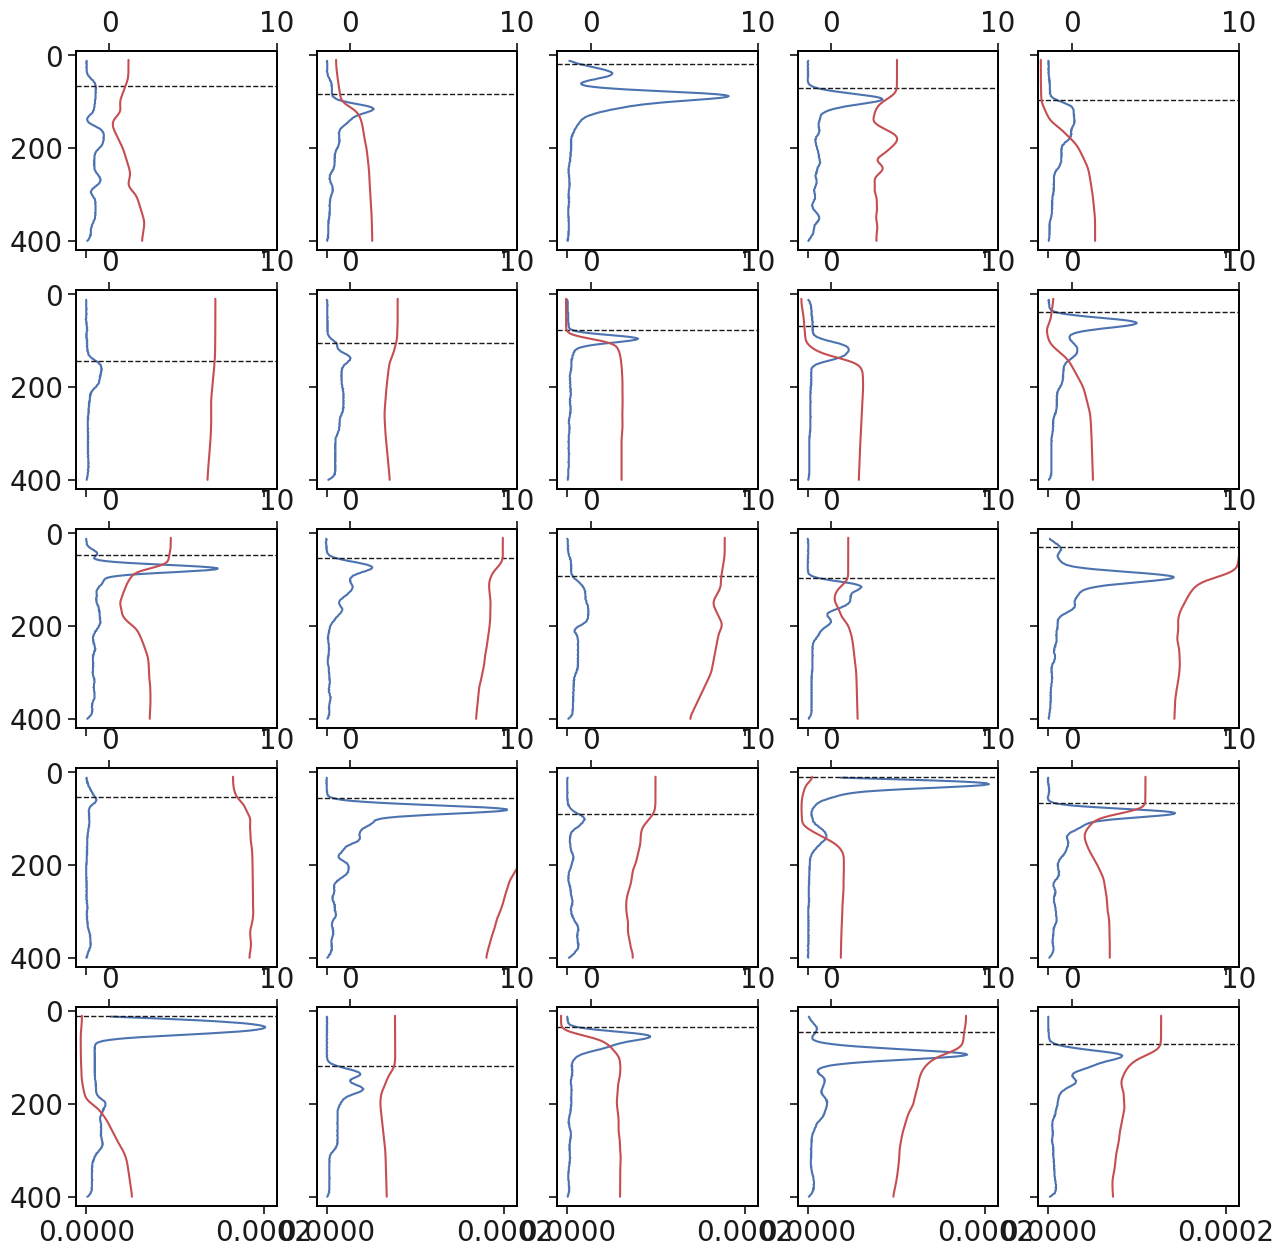

In [32]:
# integers to loop through:
lp = np.asarray(np.random.choice(ds.n_prof.size,25,replace=False))

fig,ax = plt.subplots(5,5,figsize=(15,15),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for l,a, in zip(lp,ax,):
    a.plot(n2[l],pres)
    a.axhline(mlp[l],c='k',lw=1,ls='--')
    a = a.twiny()
    a.plot(ct[l],pres,c='r')
    a.set_xlim(-2,10)

a.invert_yaxis()

# n2 WW detection

In [2]:
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/superseded/ww_gauss_smoothed_ds-preDec23.nc')

In [3]:
ds_ss = ds.isel(n_prof = np.where(ds.ww_type==2)[0]).copy()

In [9]:
#n2 = ds_ss.n2
n2 = (-9.8/1025 * ds_ss.sig.diff(dim='pres') / -ds_ss.pres.diff('pres'))
ct = ds_ss.ctemp
cp = ds_ss.ww_cp.data
ub = ds_ss.lw_bd.data
lb = ds_ss.up_bd.data
mlp = ds_ss.mlp.data
pres = ds_ss.pres.data

In [4]:
#ds_tmp = ds_ss.isel(n_prof=np.where(ds_ss.ww_ct>0)[0]).copy()

# select only summer data
# should actually check autumn data
ds_tmp = ds_ss.isel(n_prof=np.where(ds_ss.time.dt.month == np.any([12,1,2]))[0]).copy()

In [7]:
# calculate n2 and add to ds
n2 = (-9.8/1025 * ds_tmp.sig.diff(dim='pres') / -ds_tmp.pres.diff('pres'))
#n2 = ds_tmp.n2
ct = ds_tmp.ctemp
cp = ds_tmp.ww_cp.data
ub = ds_tmp.lw_bd.data
lb = ds_tmp.up_bd.data
mlp = ds_tmp.mlp.data
pres = ds_tmp.pres.data

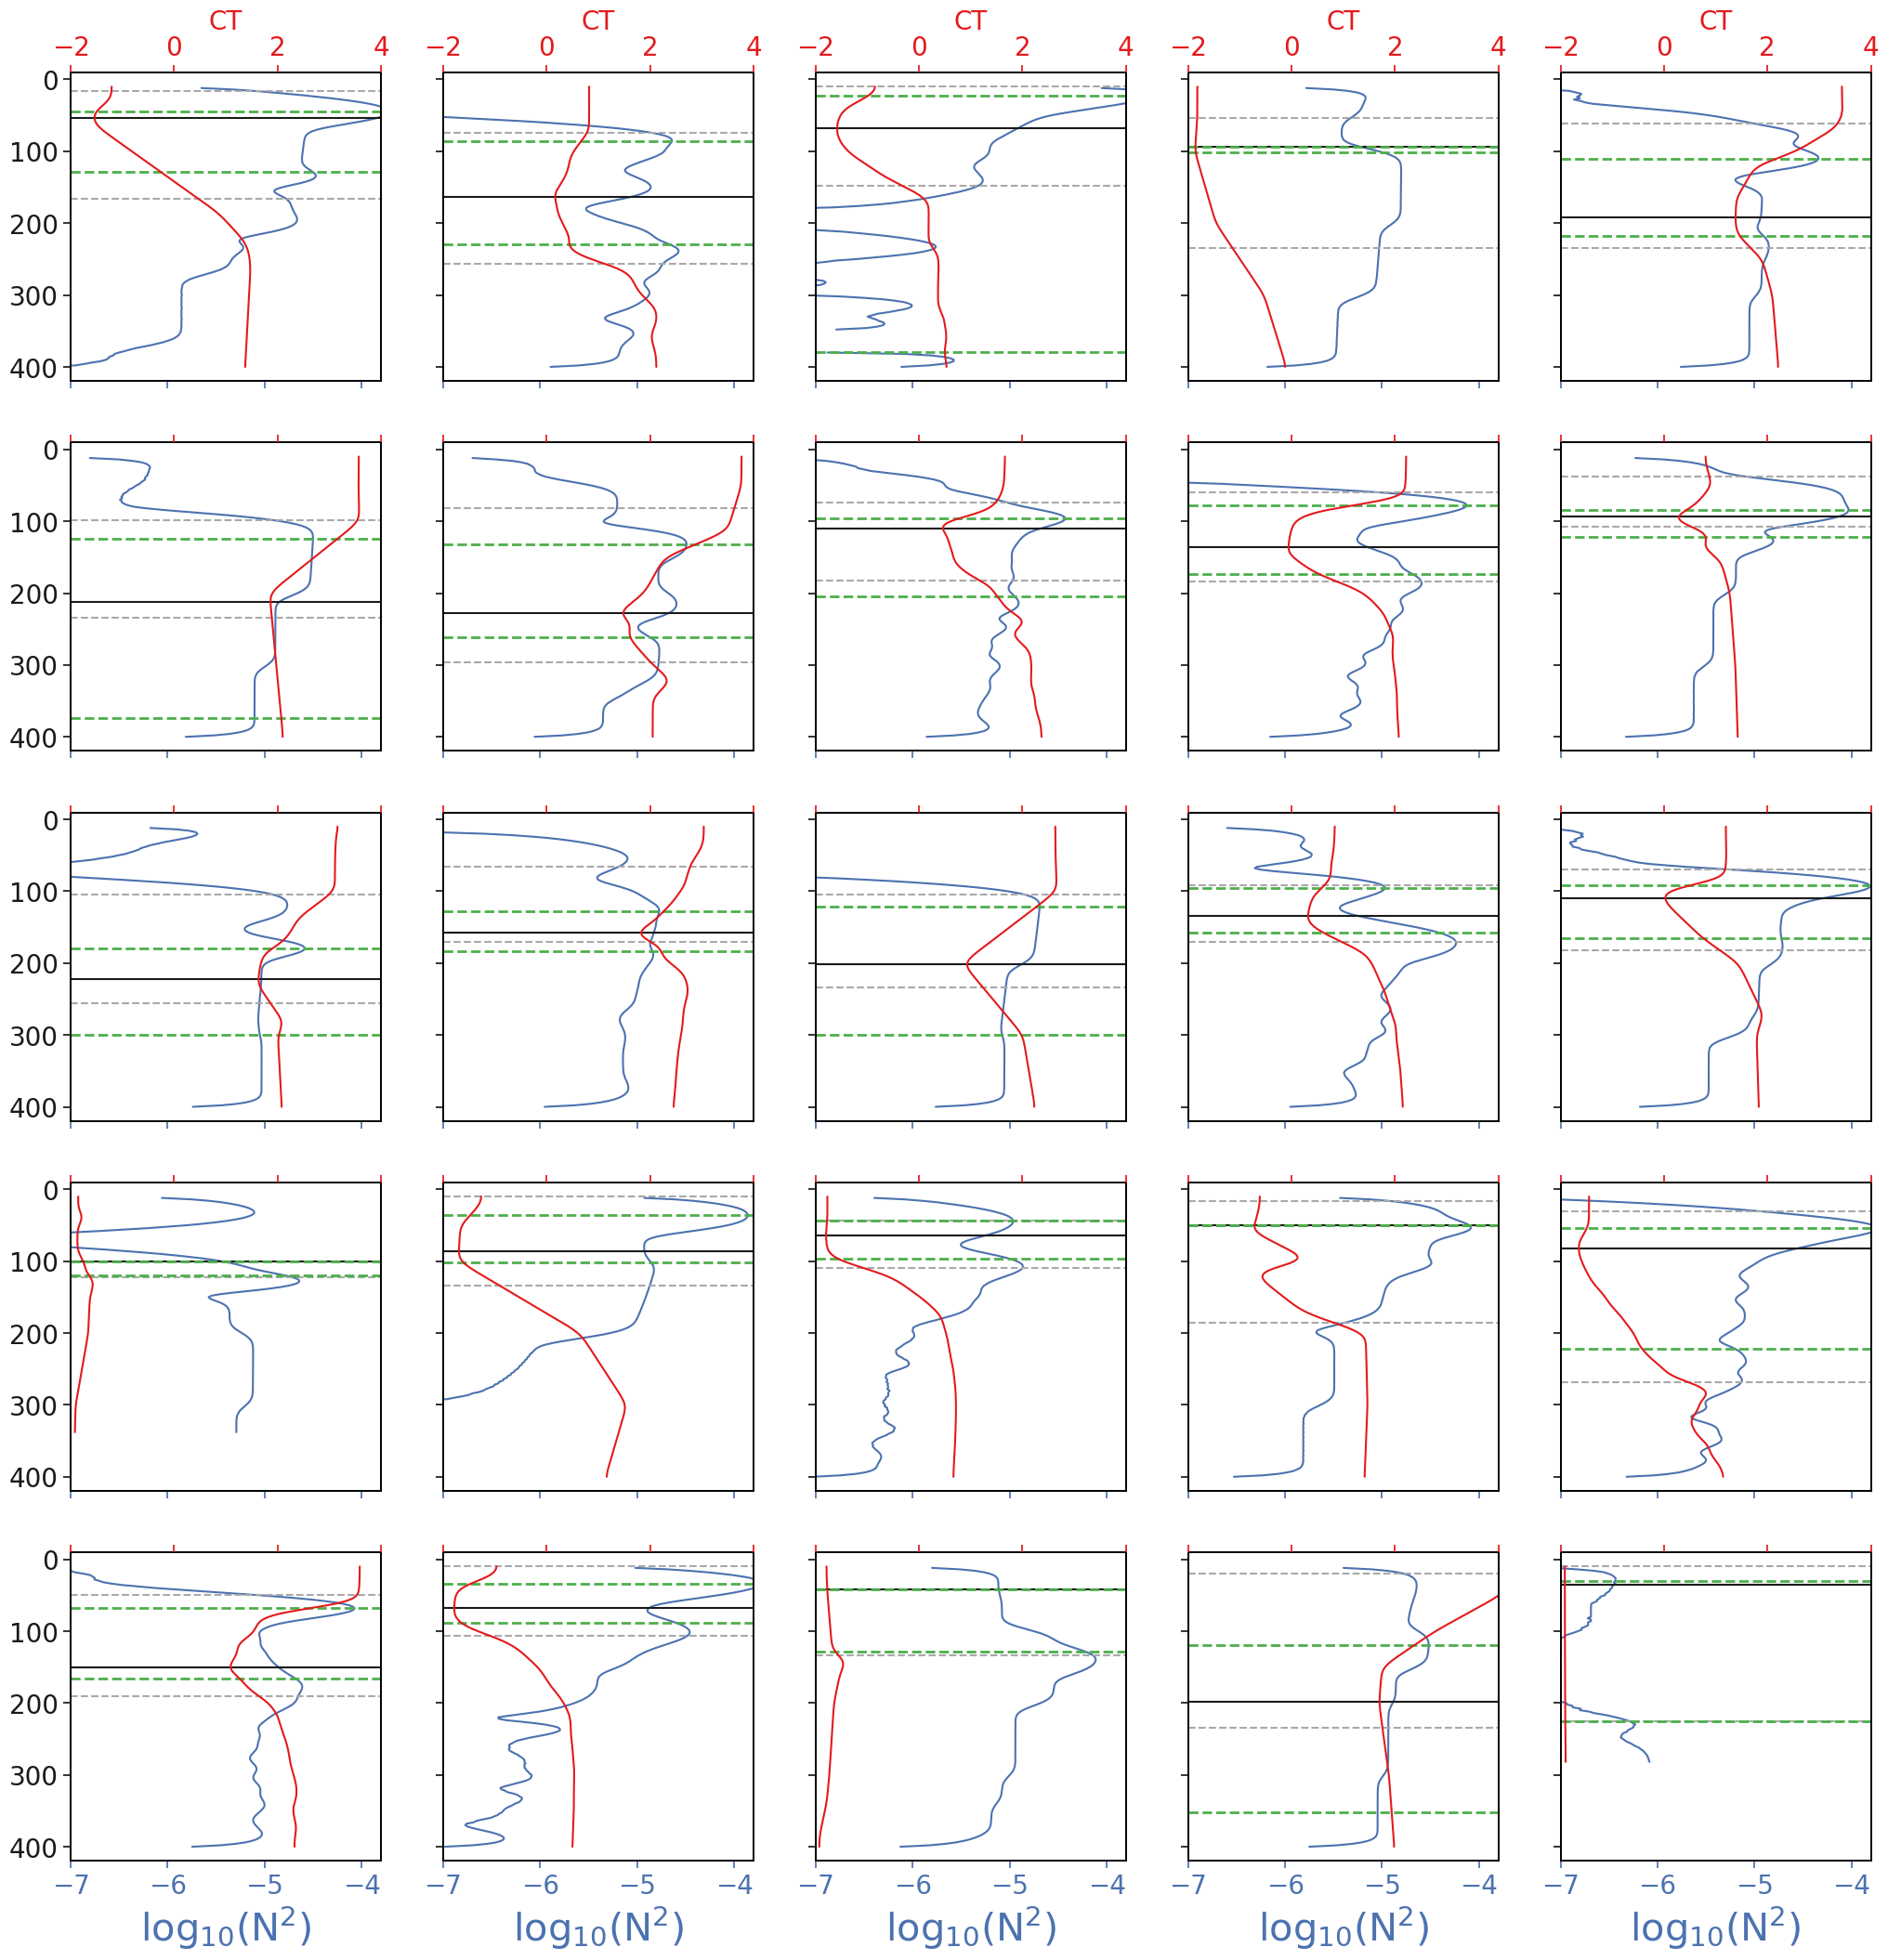

In [11]:
# integers to loop through:
r = 5
lp = np.asarray(np.random.choice(ds_ss.n_prof.size,r**2,replace=False))
#lp = np.asarray(np.random.choice(ds_tmp.n_prof.size,r**2,replace=False))

fig,ax = plt.subplots(r,r,figsize=(25,25),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for i,l,a, in zip(range(len(ax)),lp,ax,):
    tmp = n2[l]#.rolling({'pres':20},min_periods=1).mean()
    tmp_diff = tmp.diff('pres')
    a.plot(np.log10(tmp),pres[1:])
    a.tick_params(axis='x', colors='b')
    #a.plot(tmp.diff('pres'),pres[1:],alpha=0.5)
    # already calculated boundaries
    a.axhline(ub[l],c='darkgrey',ls='--')
    a.axhline(lb[l],c='darkgrey',ls='--')
    a.axhline(cp[l],c='k',)
    # boundaries as per n2 definition:
    if cp[l]>10:
        g = '#4daf4a'
        a.axhline(tmp.sel(pres=slice(mlp[l],cp[l])).idxmax(),c=g,ls='--',lw=2) # ub
        a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
        #a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).__abs__().idxmin(),c=g,ls='--',lw=2) # lb
    if i in range(r**2-r,r**2):
        a.set_xlabel(r'log$_{10}$(N$^2$)',c='b')
        a.set_xlim(-7,-3.8)

    # add temperature
    a = a.twiny()
    red = '#e41a1c'
    a.plot(ct[l],pres,c=red)
    a.set_xlim(-2,4)
    a.tick_params(axis='x', colors=red)
    if i in range(r,r**2):
        a.set_xticklabels('')
    else:
        a.set_xlabel('CT',fontsize=20,c=red)

a.invert_yaxis()

In [28]:
ds_tmp

<xarray.Dataset>
Dimensions:  (n_prof: 18014, pres: 196)
Coordinates:
  * n_prof   (n_prof) int64 0 1 2 4 5 7 ... 601402 601403 601409 601415 601417
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
    lon      (n_prof) float64 ...
    lat      (n_prof) float64 ...
    time     (n_prof) datetime64[ns] 2004-01-01T10:01:28.999999744 ... 2021-0...
Data variables: (12/20)
    temp     (n_prof, pres) float64 ...
    psal     (n_prof, pres) float64 ...
    dsource  (n_prof) object ...
    mld      (n_prof) float64 ...
    asal     (n_prof, pres) float32 ...
    ctemp    (n_prof, pres) float32 ...
    ...       ...
    sig_c    (n_prof) float64 ...
    lw_bd    (n_prof) float64 118.0 164.0 124.0 150.0 ... 100.0 150.0 144.0
    ww_type  (n_prof) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    thcc     (n_prof) float64 ...
    ww_n2    (n_prof) float64 ...
    ww_msk   (n_prof, pres) float64 ...
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

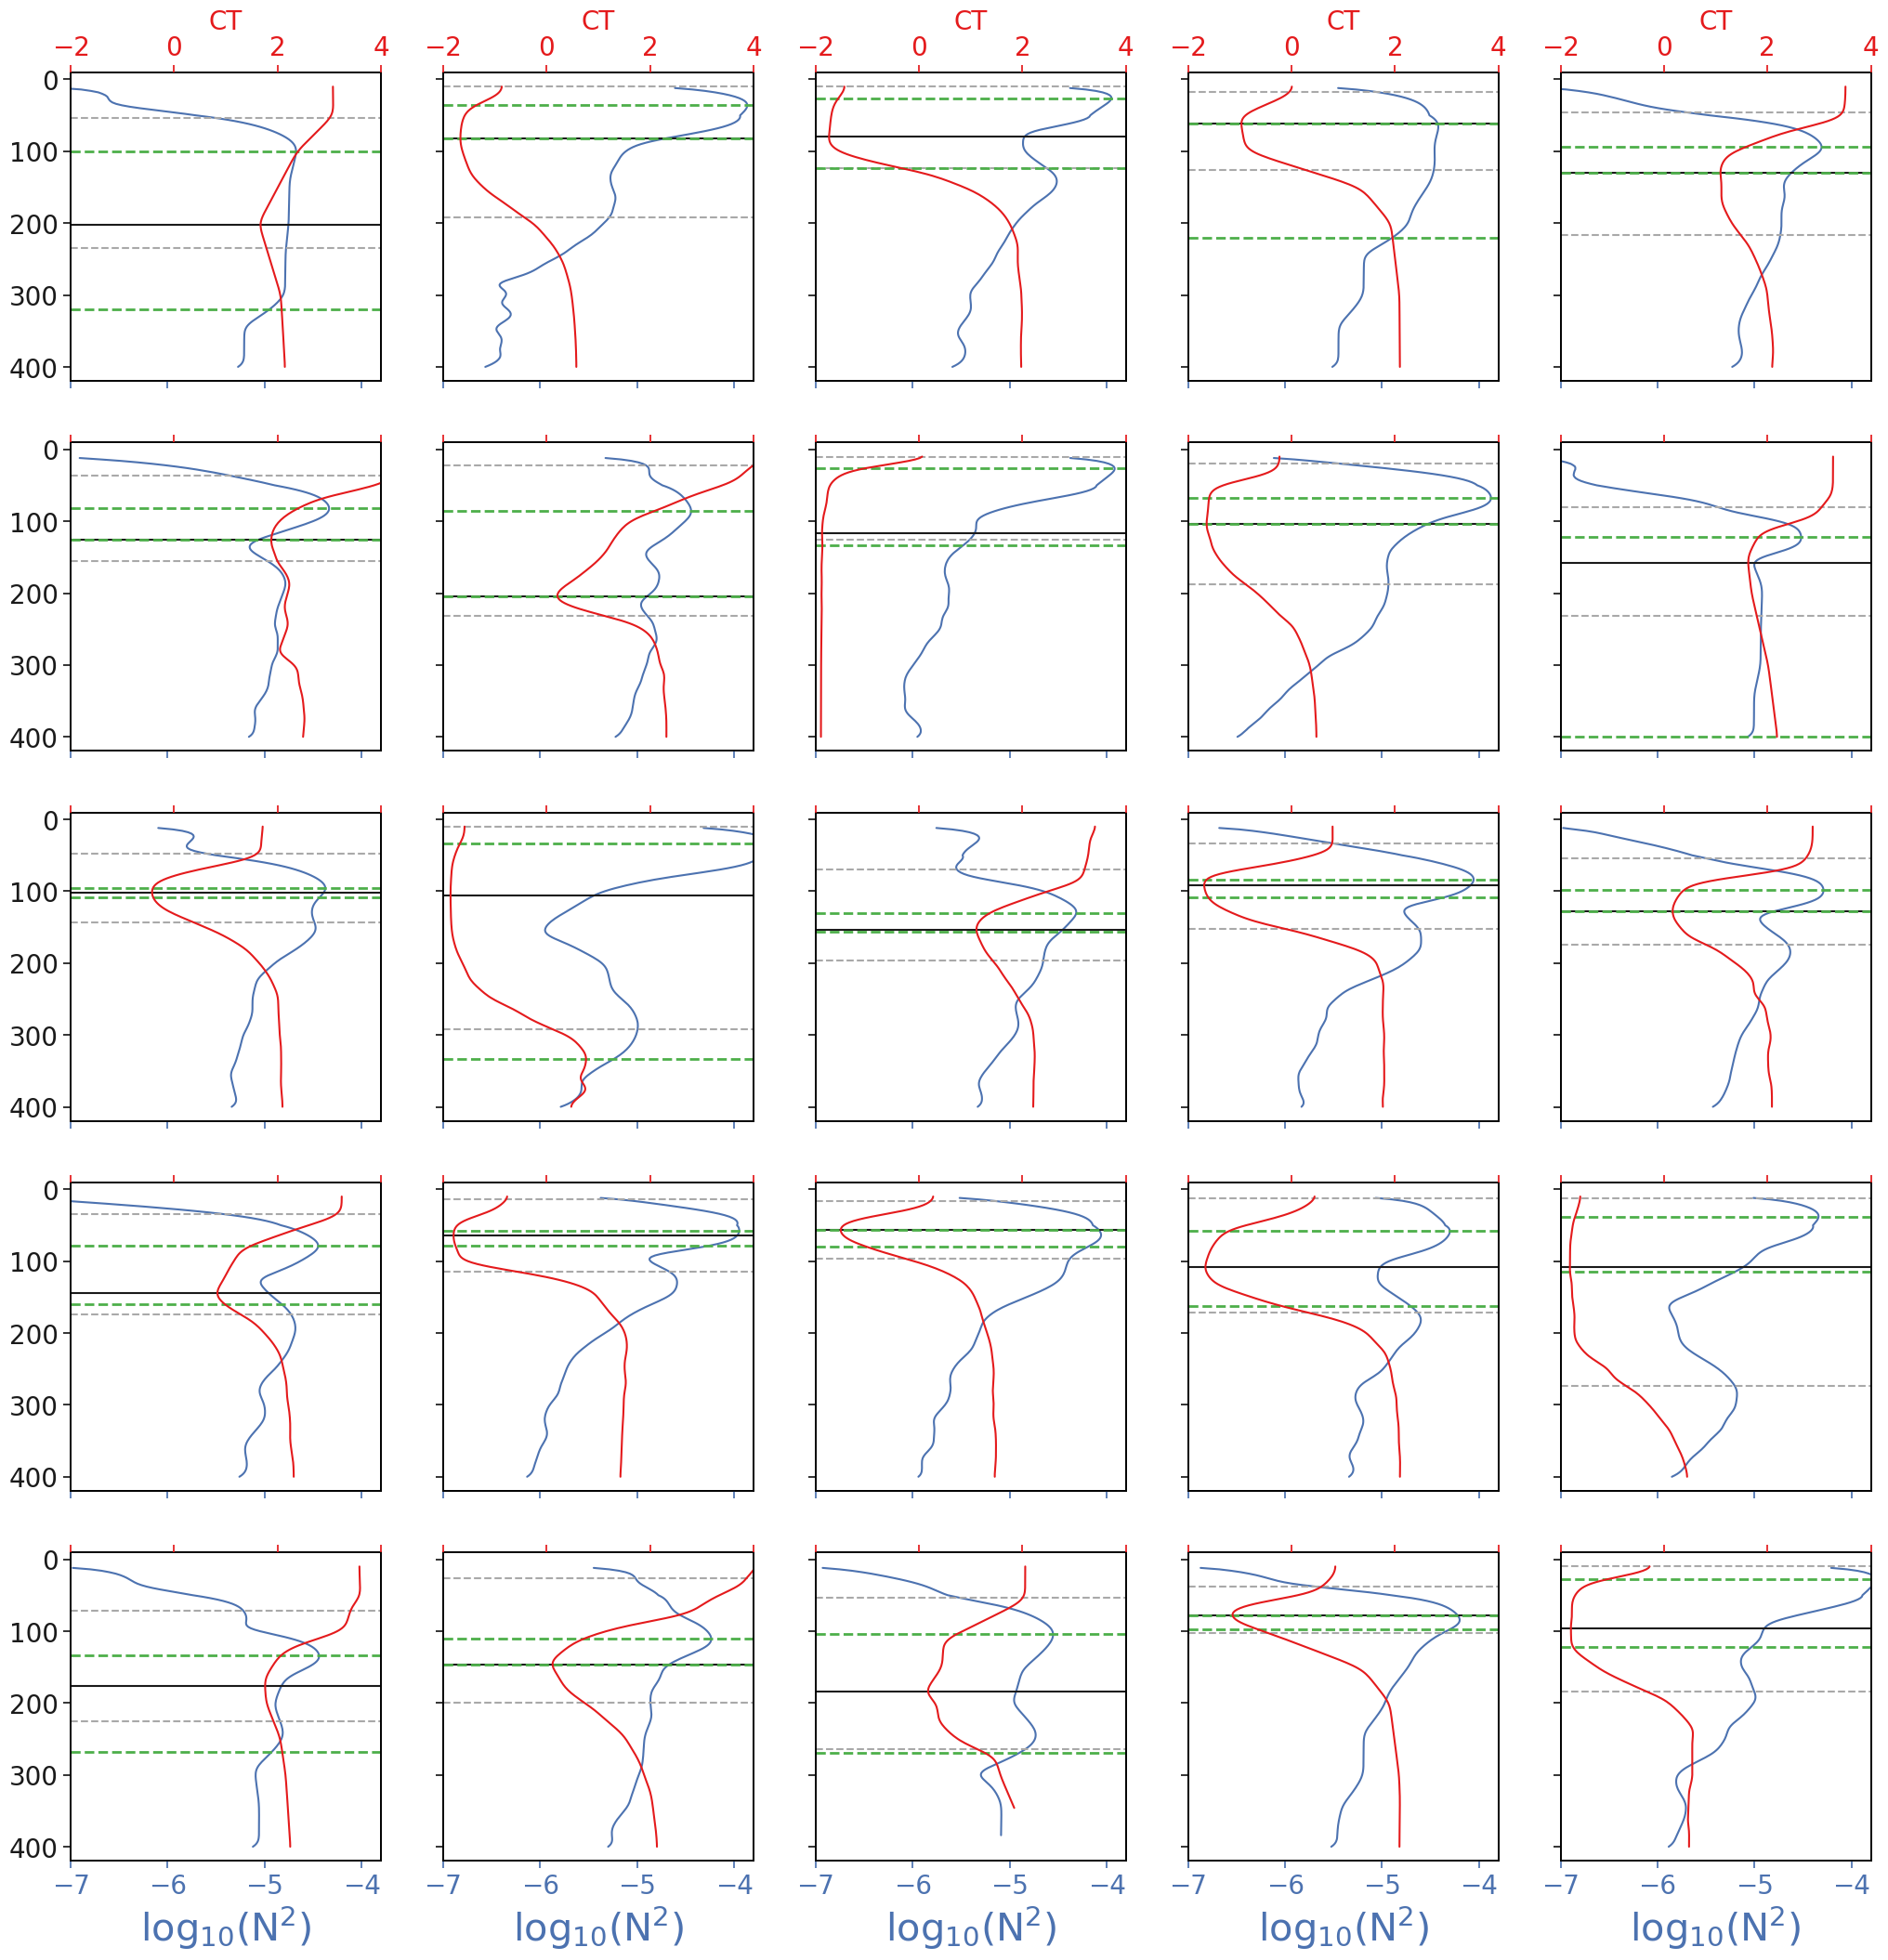

In [62]:
# integers to loop through:
#r = 5
#lp = np.asarray(np.random.choice(ds_tmp.n_prof.size,r**2,replace=False))

fig,ax = plt.subplots(r,r,figsize=(25,25),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for i,l,a, in zip(range(len(ax)),lp,ax,):
    tmp = n2[l].rolling({'pres':20},min_periods=1).mean()
    #tmp = ct[l]
    tmp_diff = tmp.diff('pres')
    a.plot(np.log10(tmp),pres[1:])
    a.tick_params(axis='x', colors='b')
    #a.plot(tmp.diff('pres'),pres[1:],alpha=0.5)
    # already calculated boundaries
    a.axhline(ub[l],c='darkgrey',ls='--')
    a.axhline(lb[l],c='darkgrey',ls='--')
    a.axhline(cp[l],c='k',)
    # boundaries as per n2 definition:
    if cp[l]>10:
        g = '#4daf4a'
        a.axhline(tmp.sel(pres=slice(mlp[l],cp[l])).idxmax(),c=g,ls='--',lw=2) # ub
        #a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
        a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).__abs__().idxmax(),c=g,ls='--',lw=2) # lb
    if i in range(r**2-r,r**2):
        a.set_xlabel(r'log$_{10}$(N$^2$)',c='b')
        a.set_xlim(-7,-3.8)

    # add temperature
    a = a.twiny()
    red = '#e41a1c'
    a.plot(ct[l],pres,c=red)
    a.set_xlim(-2,4)
    a.tick_params(axis='x', colors=red)
    if i in range(r,r**2):
        a.set_xticklabels('')
    else:
        a.set_xlabel('CT',fontsize=20,c=red)

a.invert_yaxis()

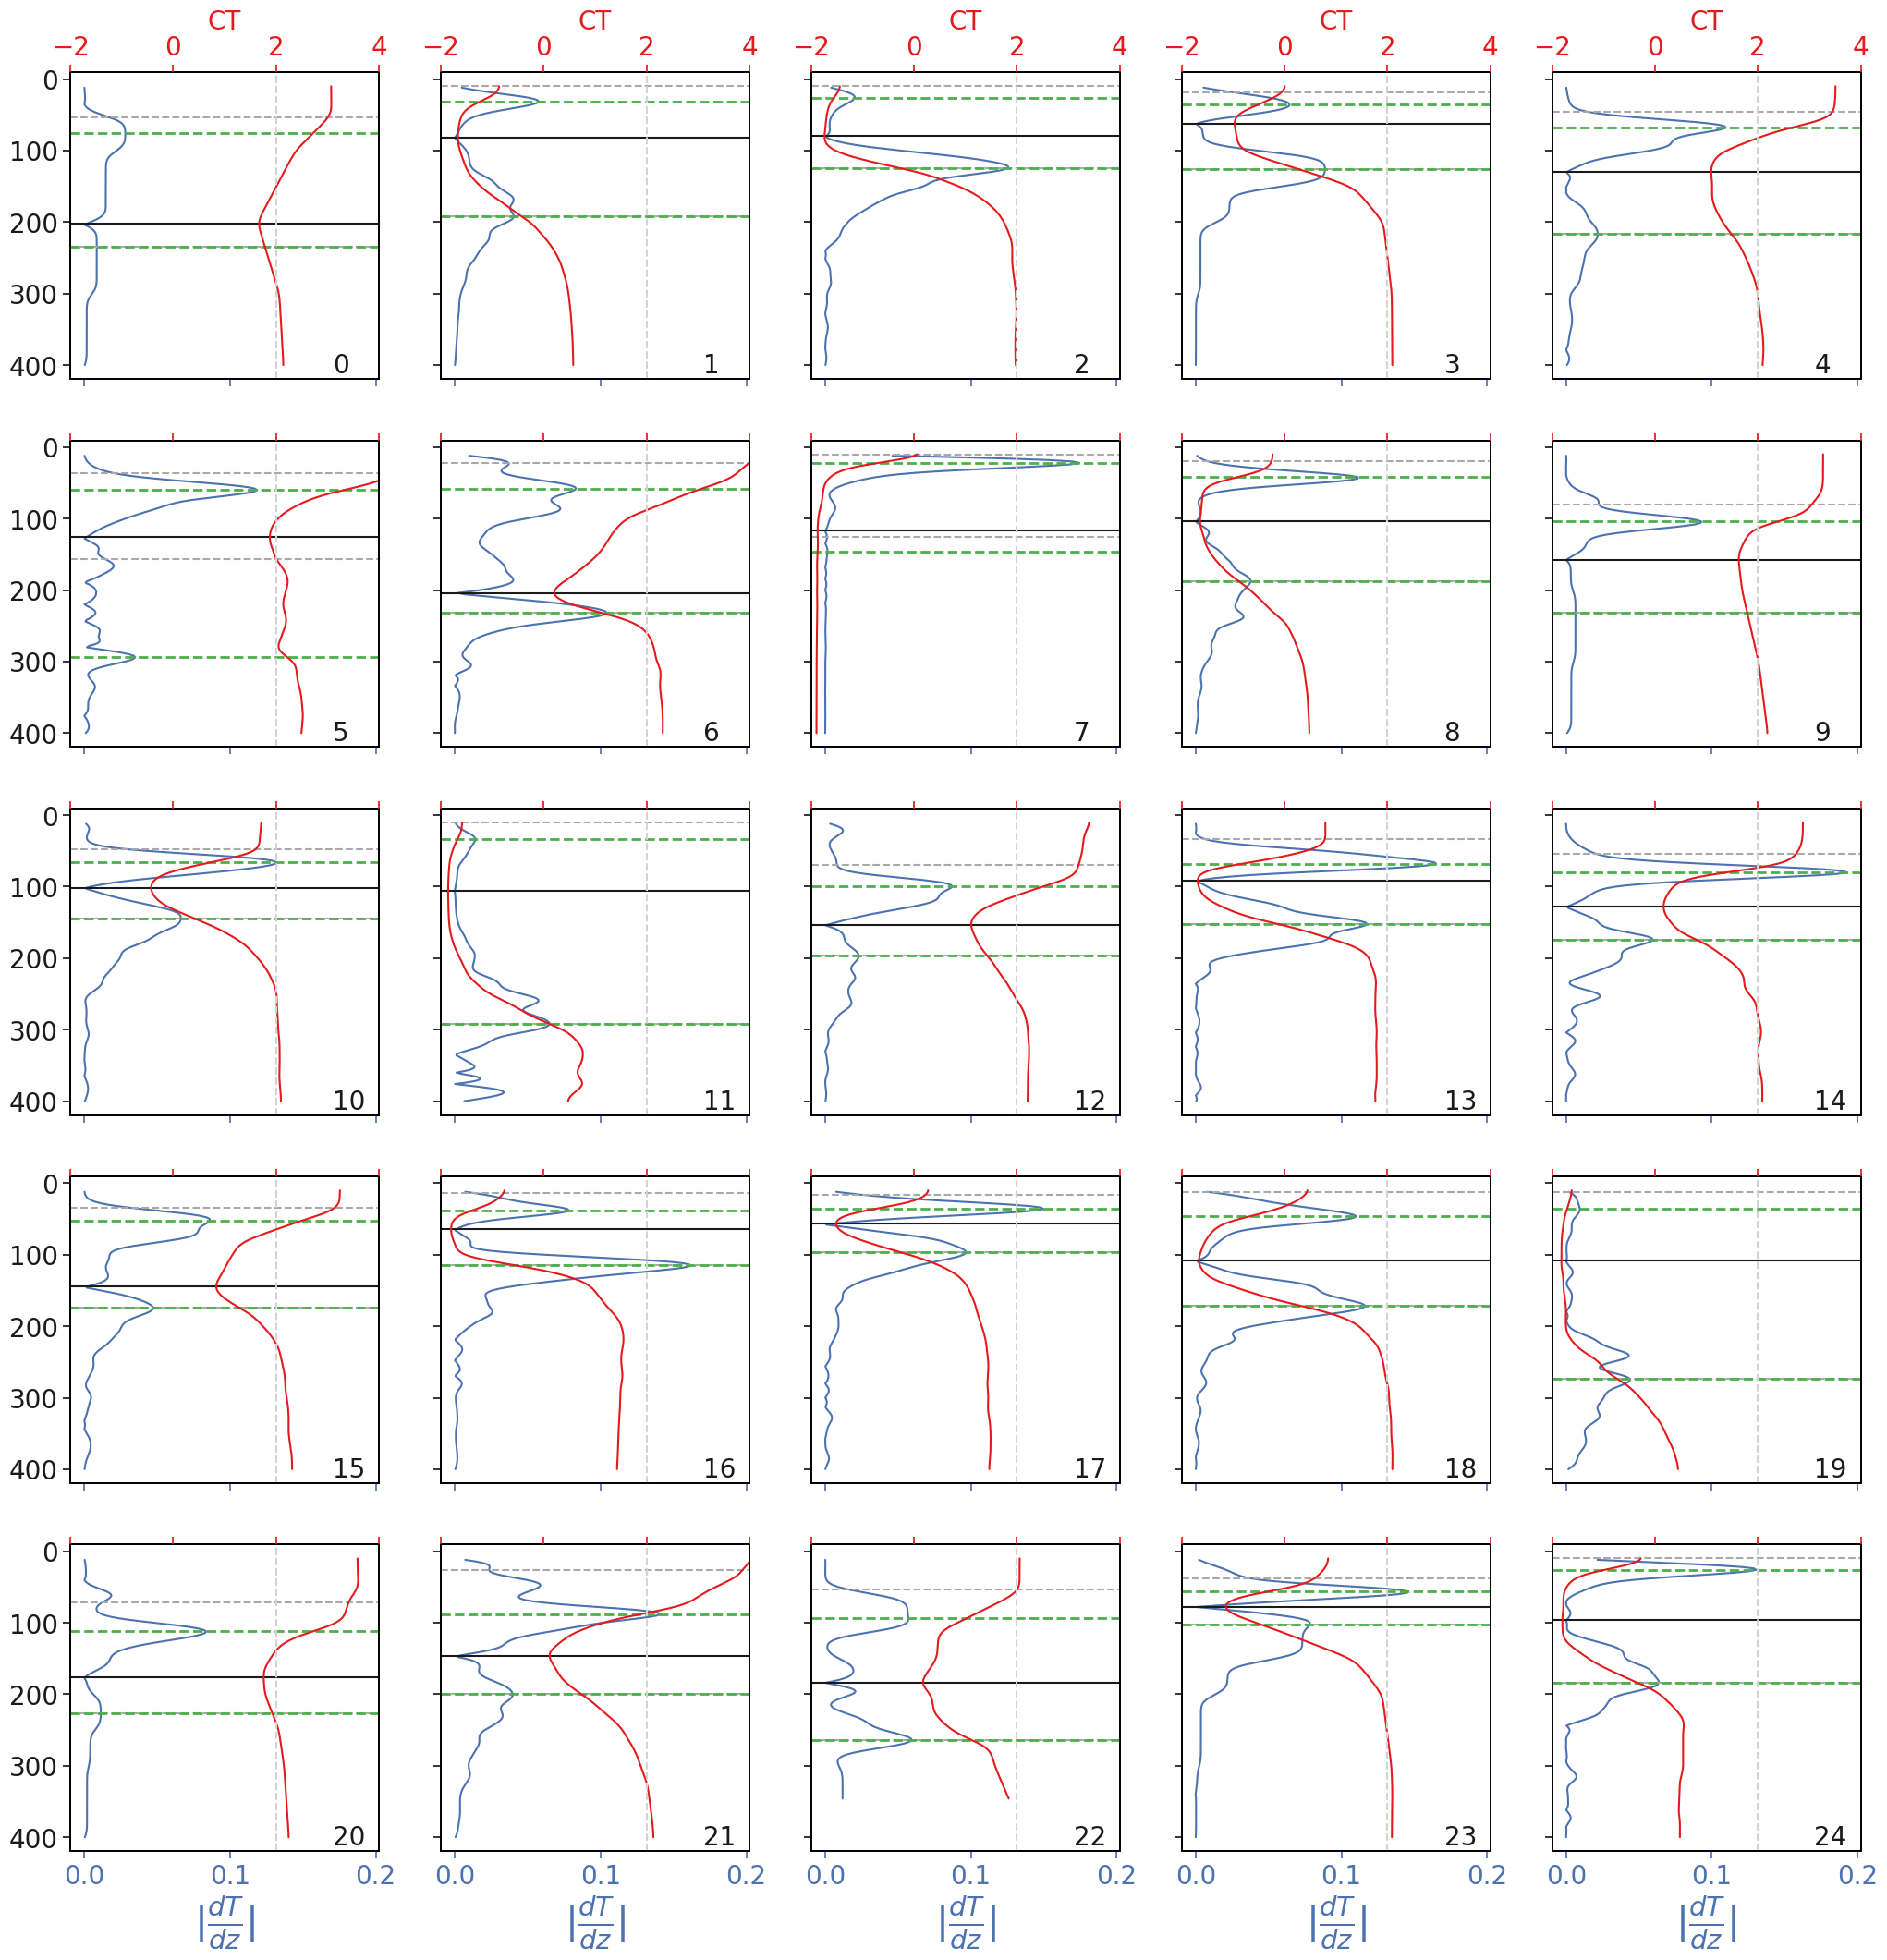

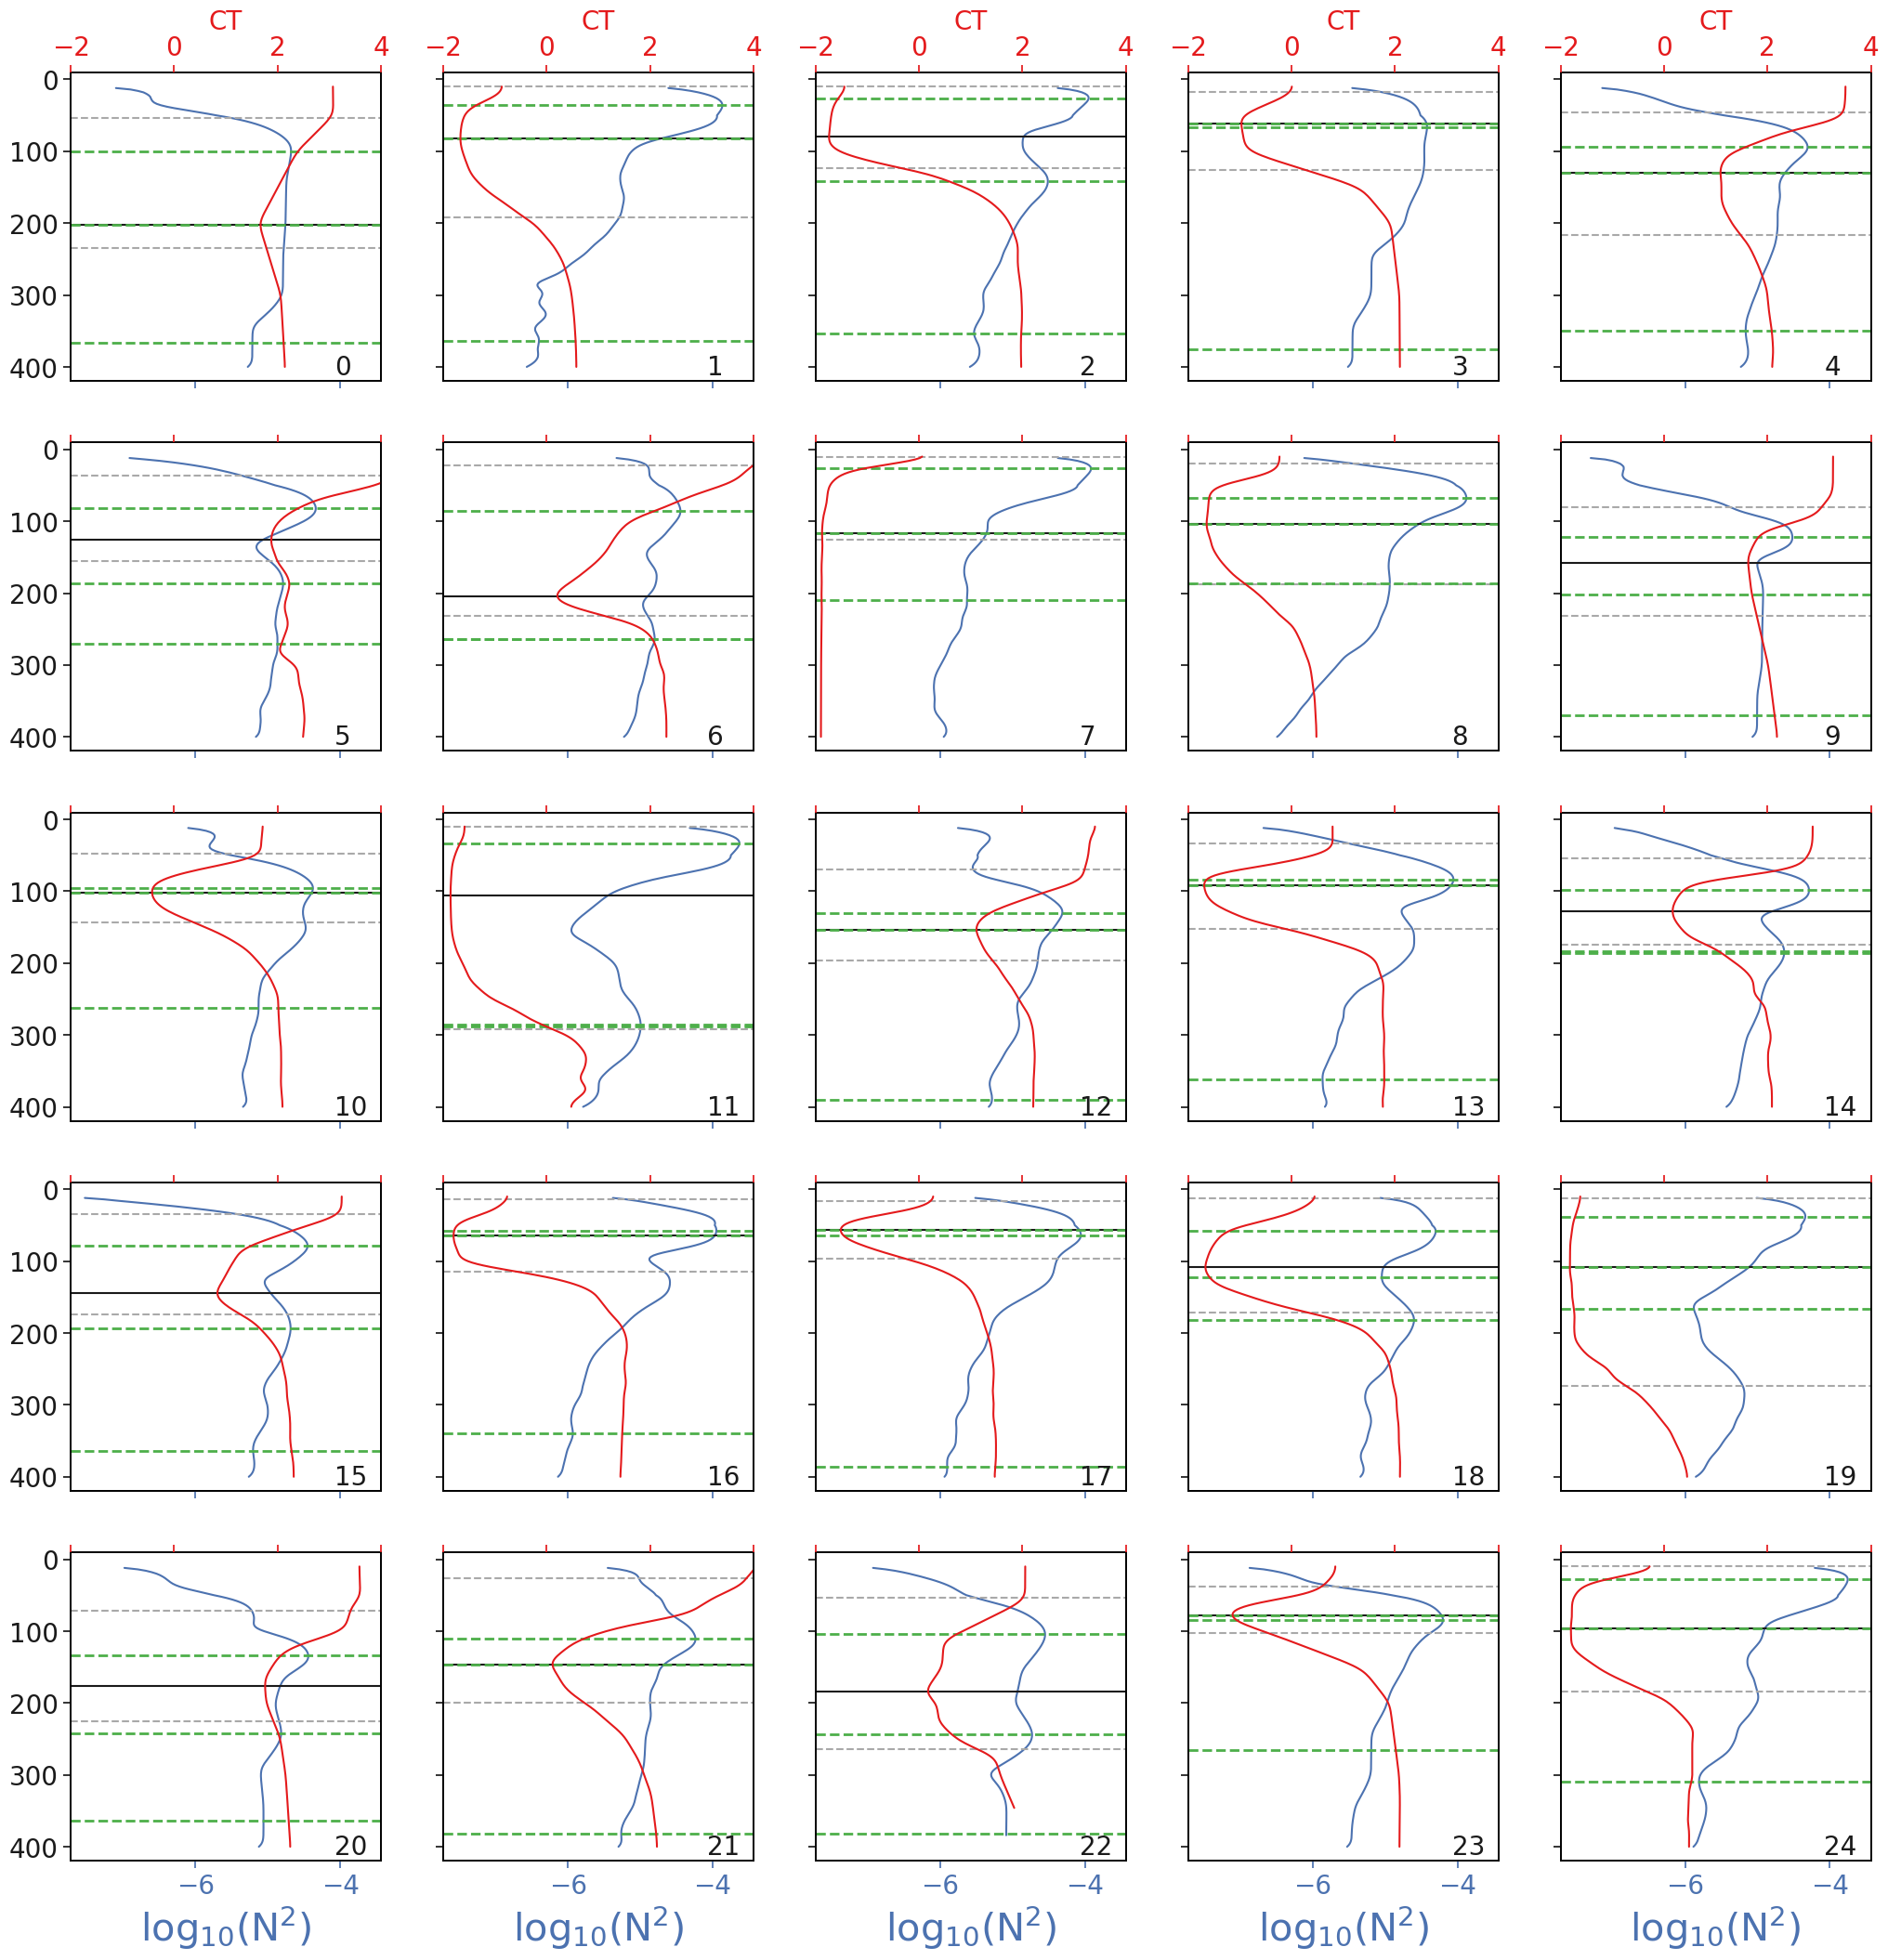

In [56]:
# integers to loop through:
#r = 5
#lp = np.asarray(np.random.choice(ds_tmp.n_prof.size,r**2,replace=False))

fig,ax = plt.subplots(r,r,figsize=(25,25),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for i,l,a, in zip(range(len(ax)),lp,ax,):
    #tmp = n2[l].rolling({'pres':20},min_periods=1).mean()
    tmp = ct[l]
    tmp_diff = tmp.diff('pres').__abs__()
    #a.plot(np.log10(tmp),pres[1:])
    a.tick_params(axis='x', colors='b')
    a.plot(tmp_diff,pres[1:],)
    # already calculated boundaries
    a.axhline(ub[l],c='darkgrey',ls='--')
    a.axhline(lb[l],c='darkgrey',ls='--')
    a.axhline(cp[l],c='k',)
    # boundaries as per n2 definition:
    if cp[l]>10:
        g = '#4daf4a'
        a.axhline(tmp_diff.sel(pres=slice(mlp[l],cp[l])).idxmax(),c=g,ls='--',lw=2) # ub
        a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
        #a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).__abs__().idxmin(),c=g,ls='--',lw=2) # lb
    if i in range(r**2-r,r**2):
        a.set_xlabel(r'$|\frac{dT}{dz}|$',c='b')
        #a.set_xlabel(r'dN^2/dz',c='b')
        #a.set_xlim(-7,-3.8)

    a.annotate(i,(0.85,0.02),xycoords='axes fraction')

    # add temperature
    a = a.twiny()
    red = '#e41a1c'
    a.plot(ct[l],pres,c=red)
    a.axvline(2,c='lightgrey',ls='--')
    a.set_xlim(-2,4)
    a.tick_params(axis='x', colors=red)
    if i in range(r,r**2):
        a.set_xticklabels('')
    else:
        a.set_xlabel('CT',fontsize=20,c=red)

a.invert_yaxis()

# integers to loop through:
#r = 5
#lp = np.asarray(np.random.choice(ds_tmp.n_prof.size,r**2,replace=False))

fig,ax = plt.subplots(r,r,figsize=(25,25),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for i,l,a, in zip(range(len(ax)),lp,ax,):
    tmp = n2[l].rolling({'pres':20},min_periods=1).mean()
    #tmp = ct[l]
    tmp_diff = tmp.diff('pres').__abs__()
    a.plot(np.log10(tmp),pres[1:])
    a.tick_params(axis='x', colors='b')
    #a.plot(tmp_diff,pres[1:],)
    # already calculated boundaries
    a.axhline(ub[l],c='darkgrey',ls='--')
    a.axhline(lb[l],c='darkgrey',ls='--')
    a.axhline(cp[l],c='k',)
    # boundaries as per n2 definition:
    if cp[l]>10:
        g = '#4daf4a'
        a.axhline(tmp.sel(pres=slice(mlp[l],cp[l])).idxmax(),c=g,ls='--',lw=2) # ub
        a.axhline(tmp.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
        a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).__abs__().idxmin(),c=g,ls='--',lw=2) # lb
    if i in range(r**2-r,r**2):
        a.set_xlabel(r'log$_{10}$(N$^2$)',c='b')
        #a.set_xlabel(r'$\frac{dN^2}{dz}$',c='b')
        #a.set_xlim(-7,-3.8)

    a.annotate(i,(0.85,0.02),xycoords='axes fraction')


    # add temperature
    a = a.twiny()
    red = '#e41a1c'
    a.plot(ct[l],pres,c=red)
    a.set_xlim(-2,4)
    a.tick_params(axis='x', colors=red)
    if i in range(r,r**2):
        a.set_xticklabels('')
    else:
        a.set_xlabel('CT',fontsize=20,c=red)


a.invert_yaxis()

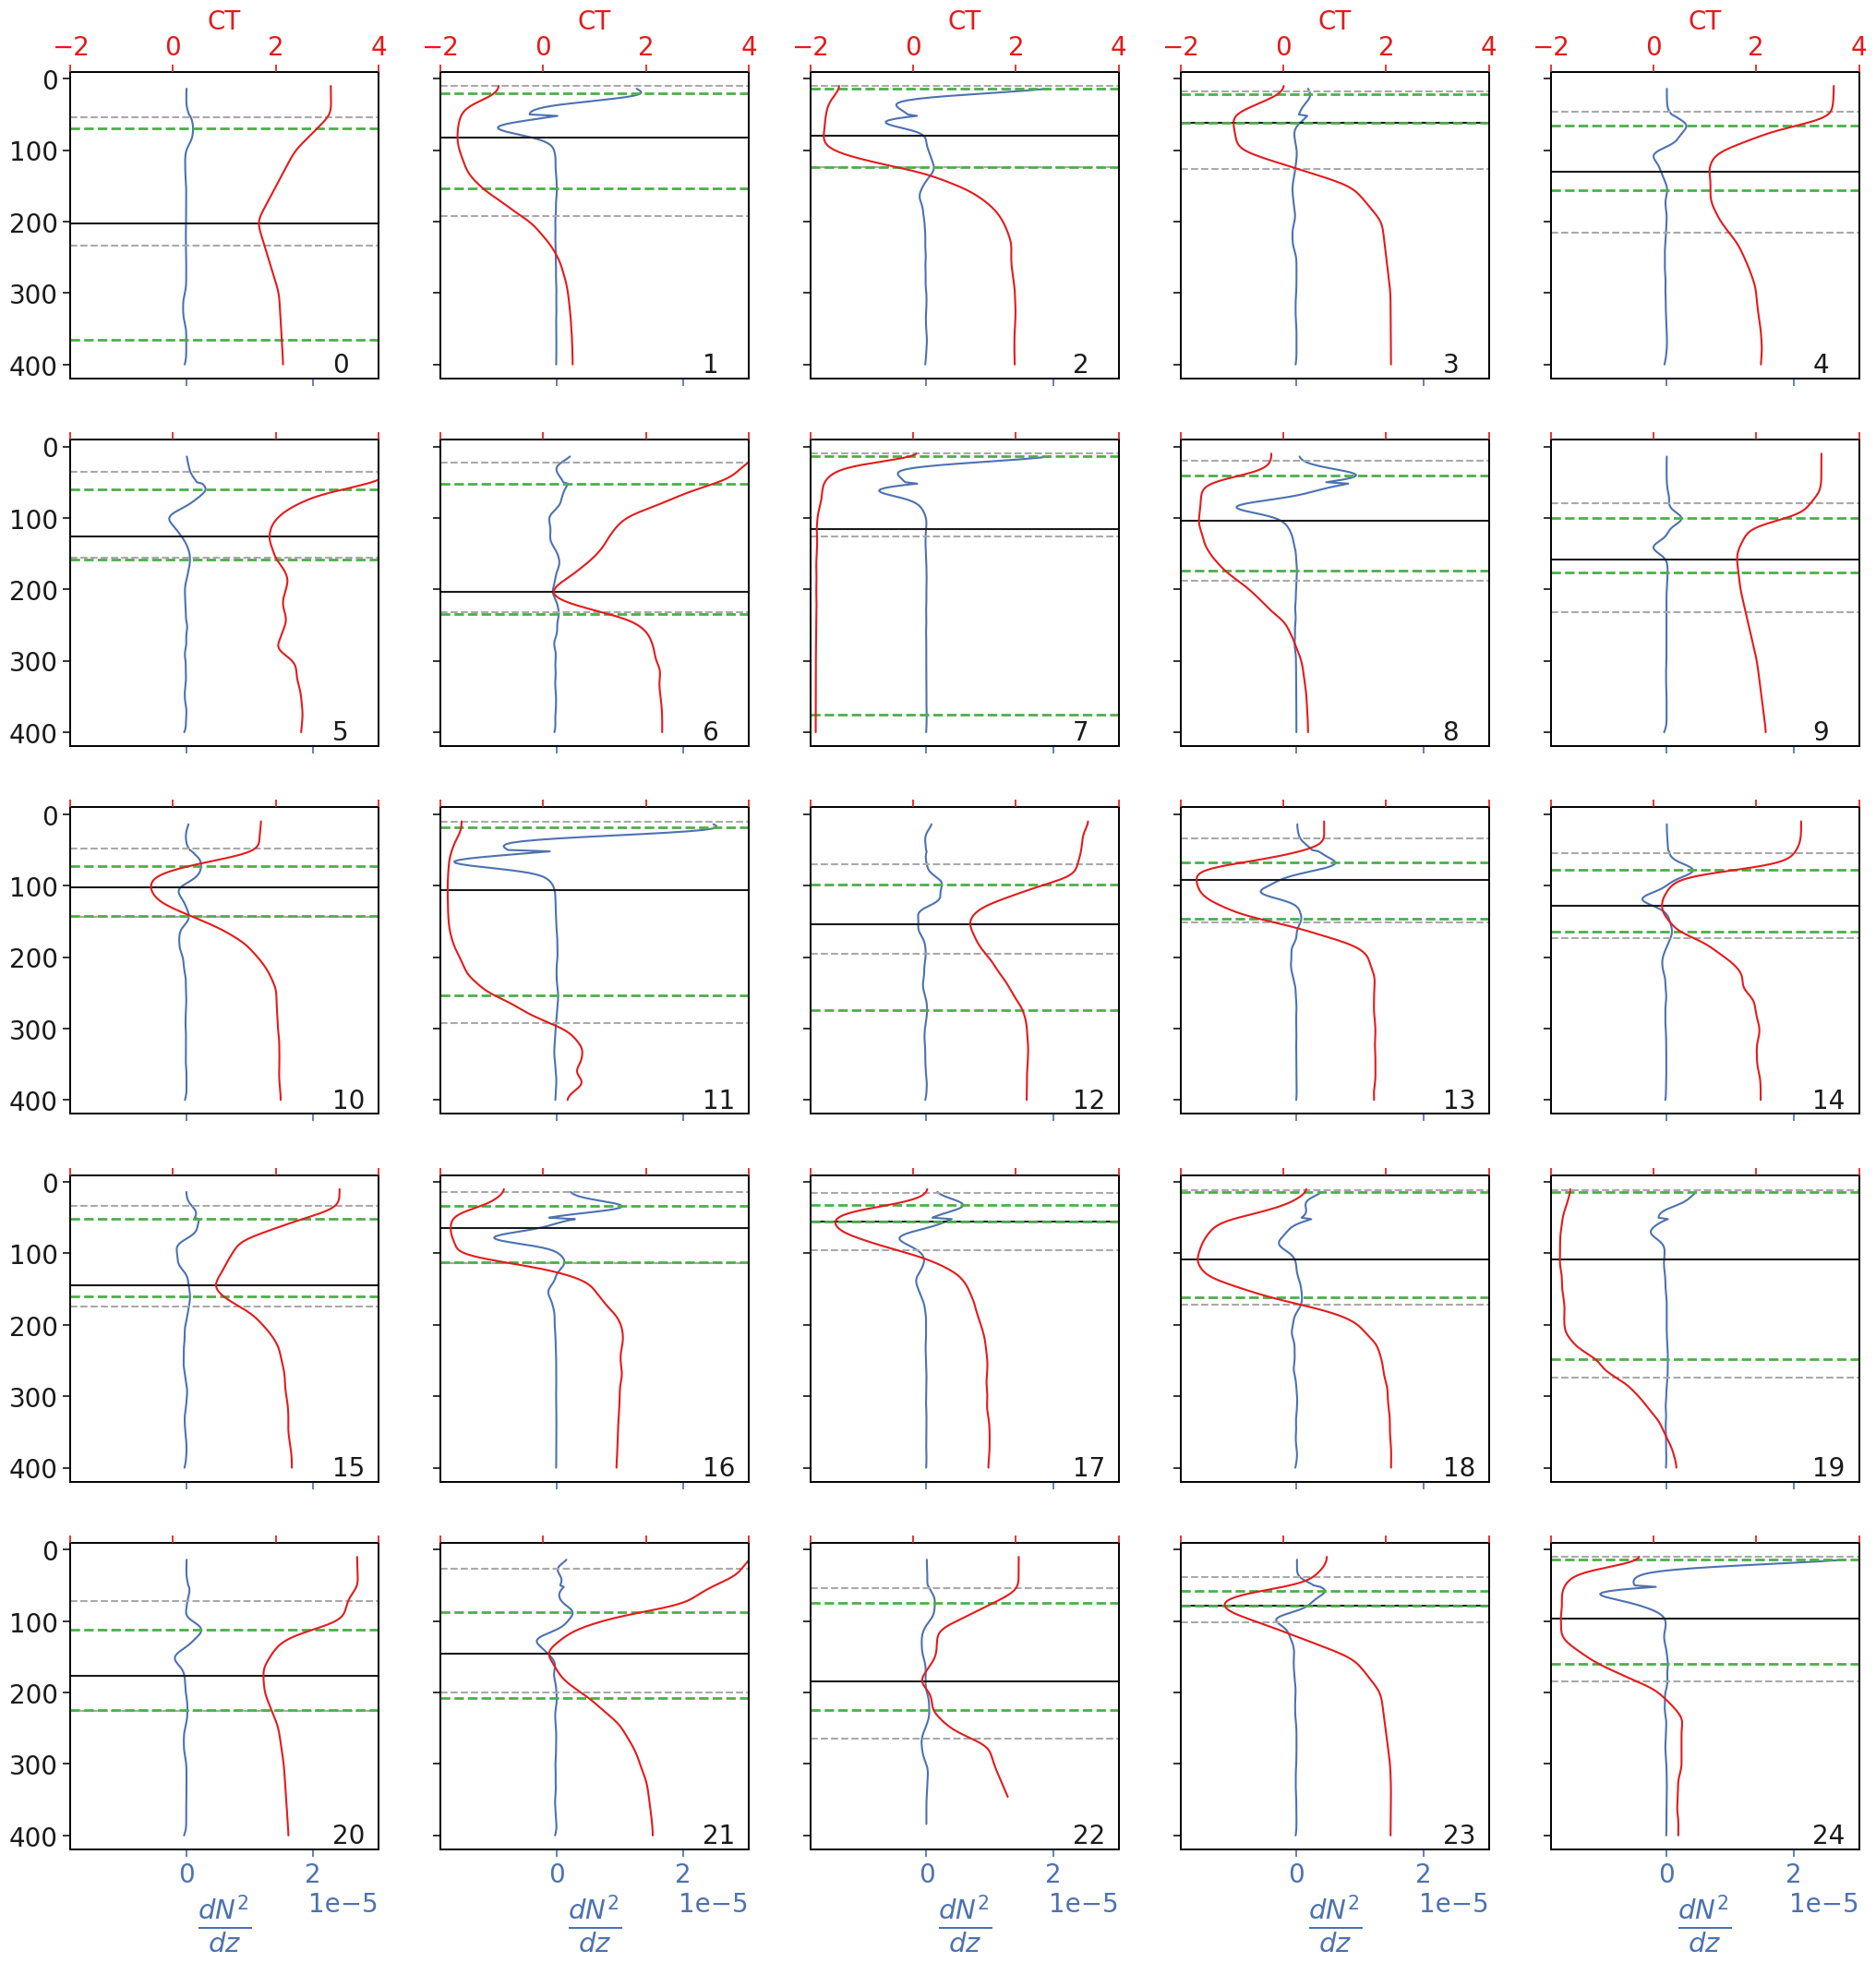

In [64]:
fig,ax = plt.subplots(r,r,figsize=(25,25),sharey=1,sharex=1)
ax = ax.flatten()

# loop over
for i,l,a, in zip(range(len(ax)),lp,ax,):
    tmp = n2[l].rolling({'pres':20},min_periods=1).mean()
    tmp_diff = tmp.diff('pres')
    #a.plot(np.log10(tmp),pres[1:])
    a.plot(tmp_diff,pres[2:],)
    a.tick_params(axis='x', colors='b')
    # already calculated boundaries
    a.axhline(ub[l],c='darkgrey',ls='--')
    a.axhline(lb[l],c='darkgrey',ls='--')
    a.axhline(cp[l],c='k',)
    # boundaries as per n2 definition:
    if cp[l]>10:
        g = '#4daf4a'
        a.axhline(tmp_diff.sel(pres=slice(mlp[l],cp[l])).idxmax(),c=g,ls='--',lw=2) # ub
        #a.axhline(tmp.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
        a.axhline(tmp_diff.sel(pres=slice(cp[l],400)).idxmax(),c=g,ls='--',lw=2) # lb
    if i in range(r**2-r,r**2):
        #a.set_xlabel(r'log$_{10}$(N$^2$)',c='b')
        a.set_xlabel(r'$\frac{dN^2}{dz}$',c='b')
        #a.set_xlim(-7,-3.8)

    # add temperature
    a = a.twiny()
    red = '#e41a1c'
    a.plot(ct[l],pres,c=red)
    a.set_xlim(-2,4)
    a.tick_params(axis='x', colors=red)
    if i in range(r,r**2):
        a.set_xticklabels('')
    else:
        a.set_xlabel('CT',fontsize=20,c=red)

    a.annotate(i,(0.85,0.02),xycoords='axes fraction')

a.invert_yaxis()